# Moteur de recommandations de films : Analyse exploratoire

Brigitte Maillère (Octobre 2018)
___
L'objectif de ce Notebook est d'effectuer le cleaning et l'exploration de la base movie_metadata.csv, avec :    

Traitements des :    
   
❒ 1. <a href='#doublons'>duplicats</a>  
❒ 2. <a href='#valeurs_aberrantes'>données aberrantes</a>    
❒ 3 .<a href='#valeurs_manquantes'>données manquantes</a> (dans ce projet, c'est l'occasion de faire de l'imputation de façon plus intéressante)   
❒ 4. <a href='#consistance'>variables inconsistantes (par exemple le budget, ou les likes facebook</a>    
❒ 5. <a href='#consistance_entre_variables'>Vérification de la consistance entre variables</a>    
❒ 6. <a href='#analyse_univariee'>Analyse univariée succinte (dans le cas des variables catégorielles, ça peut être la fréquence des différentes valeurs possibles)</a>   
❒ 7. <a href='#analyse_bivariee'>Analyse bi-variée</a>   

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
#__________________
# load the dataset
df_initial = pd.read_csv("movie_metadata.csv", low_memory=False, sep=',')
df_initial.shape

(5043, 28)

In [3]:
df_initial.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [4]:
df_initial.dtypes

color                         object
director_name                 object
num_critic_for_reviews       float64
duration                     float64
director_facebook_likes      float64
actor_3_facebook_likes       float64
actor_2_name                  object
actor_1_facebook_likes       float64
gross                        float64
genres                        object
actor_1_name                  object
movie_title                   object
num_voted_users                int64
cast_total_facebook_likes      int64
actor_3_name                  object
facenumber_in_poster         float64
plot_keywords                 object
movie_imdb_link               object
num_user_for_reviews         float64
language                      object
country                       object
content_rating                object
budget                       float64
title_year                   float64
actor_2_facebook_likes       float64
imdb_score                   float64
aspect_ratio                 float64
m

#### Affichons un aperçu du type de colonnes et leur taux de remplissage.

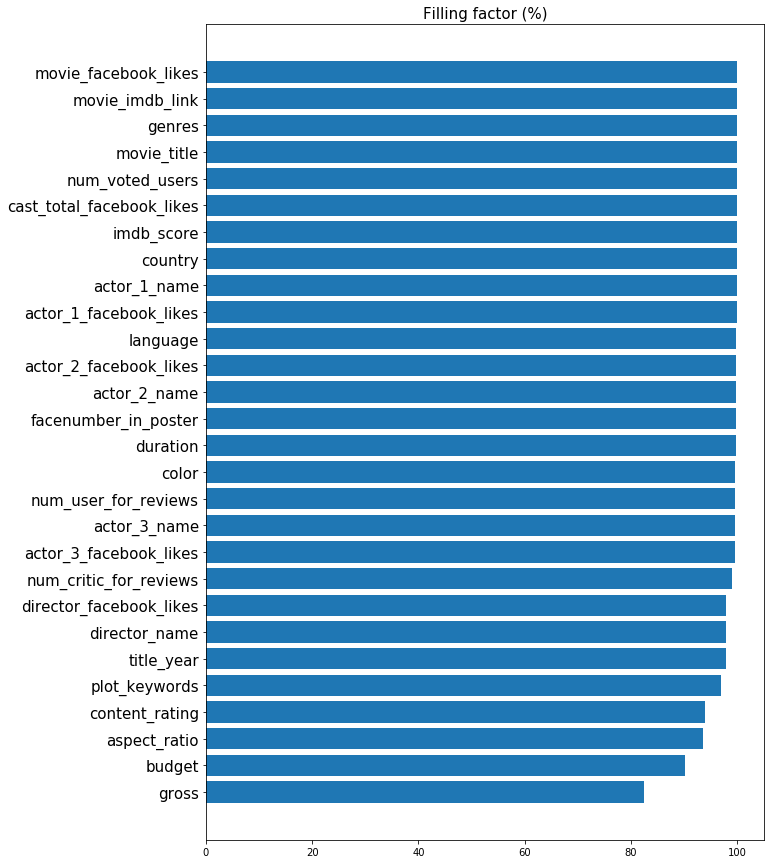

In [5]:
# This function calculates the number of missing values and the filling factor for each column of a dataset
def filling_factor(df):
    missing_df = df.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['column_name', 'missing_count']
    missing_df['filling_factor'] = (df.shape[0]-missing_df['missing_count'])/df.shape[0]*100
    missing_df = missing_df.sort_values('filling_factor').reset_index(drop = True)
    return missing_df
#____________________________________


#vision graphique
col_filling = filling_factor(df_initial)
y_axis  = list(col_filling['filling_factor'])
x_axis  = [i for i in range(len(col_filling))]
x_label = list(col_filling['column_name'])
fig = plt.figure(figsize=(10, 15))
plt.yticks(x_axis, x_label, fontsize = 15)
plt.title('Filling factor (%)', fontsize = 15)
plt.barh(x_axis, y_axis)
plt.show()


On constate que globalement les colonnes sont toutes presque complètement renseignées

In [6]:
df = df_initial.copy()

<a id='doublons'></a>

### 1. Doublons
Je supprime les doublons en conservant à chaque fois la ligne la plus complète, c'est à dire contenant le moins de valeurs nulles

In [7]:
df.movie_title.duplicated().sum()

126

In [8]:
df[['movie_title', 'director_name', 'title_year']].loc[df.movie_title.duplicated(keep = False),:].sort_values(by = 'movie_title').head()

,movie_title,director_name,title_year
3711,"20,000 Leagues Under the Sea",Richard Fleischer,1954.0
4894,"20,000 Leagues Under the Sea",Richard Fleischer,1954.0
4950,A Dog's Breakfast,David Hewlett,2007.0
4949,A Dog's Breakfast,David Hewlett,2007.0
1420,A Nightmare on Elm Street,Wes Craven,1984.0


In [9]:
# suppression des lignes contenant le plus de valeurs NaN
df['count'] = pd.isnull(df).sum(1) # counts number of NaN values in the row
df = df.sort_values(['count']).drop_duplicates(subset=['movie_title'],keep='first').drop('count',1)
df.shape

(4917, 28)

<div id = "valeurs_aberrantes">

### 2. Valeurs numériques aberrantes
Je vais les chercher en utilisant un scatterplot, puis comme je ne vois pas de valeurs aberrantes, j'affcihe en plus les 10 valeurs les plus hautes et les plus basses pour chaque colonne numérique

#### Je ne vois pas d'outliers de manière certaine. J'imprime les 10 valeurs extrèmes (max, puis min) pour chaque colonne numérique et j'affiche la ligne en entier pour avoir une compréhension des données.

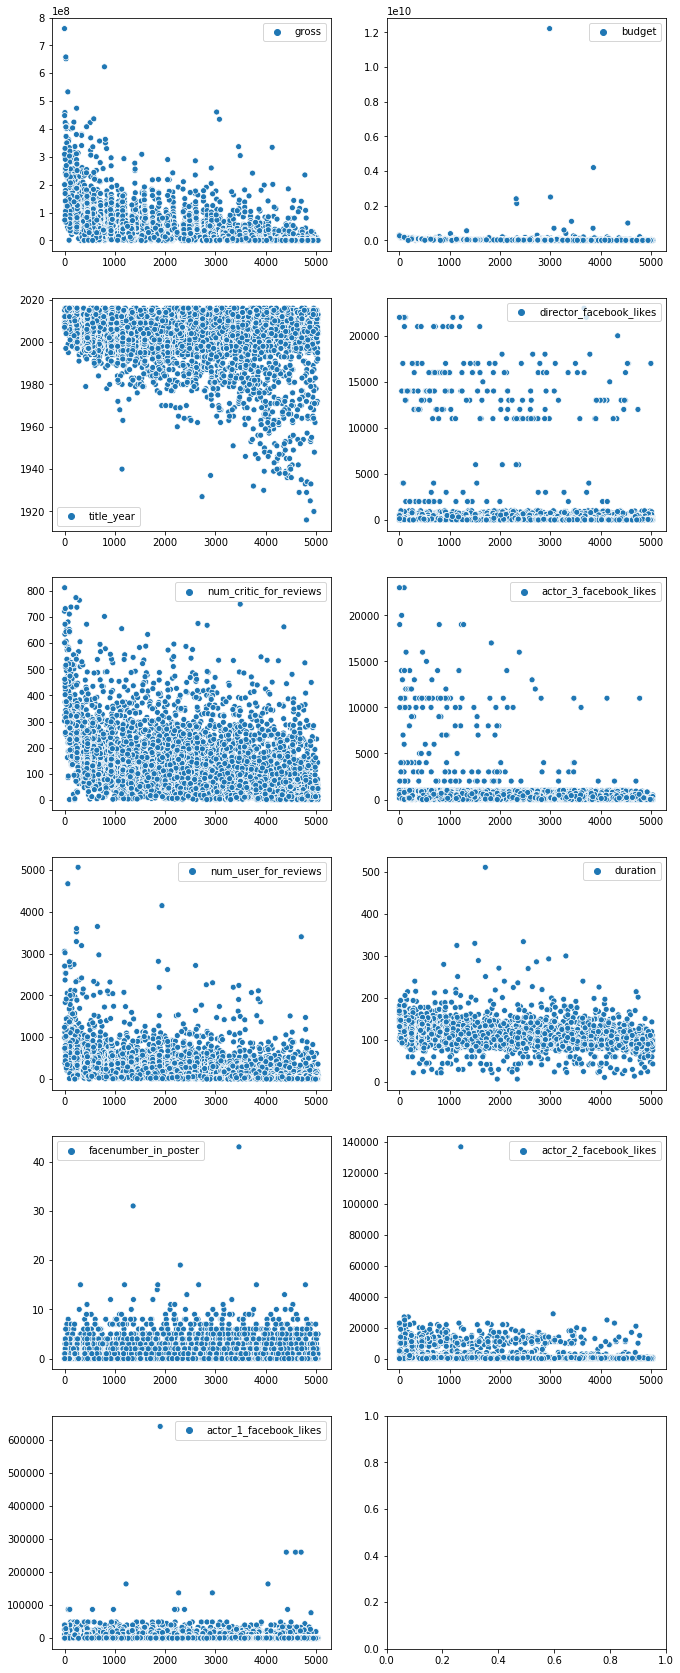

In [10]:
numeric_columns = ['gross','budget', 'title_year','director_facebook_likes','num_critic_for_reviews','actor_3_facebook_likes', 'num_user_for_reviews', 'duration', 'facenumber_in_poster', 'actor_2_facebook_likes', 'actor_1_facebook_likes']

tPlot, axes = plt.subplots(nrows=6, ncols=2, sharex=False, sharey=False, figsize=(11,30))
axes = np.array(axes)

i=0
for ax in axes.reshape(-1):
    if i < 11 : 
        column = numeric_columns[i]
        sns.scatterplot(data = df[[column]], ax = ax)
        i += 1
    
    

outliers présumés :
budget du film The Host (jamais entendu parler ...). Peut être une erreur de devise lors de la saisie.
je remplace la valeur par None, elle sera remplacée ensuite par imputation de la médiane

In [11]:
from IPython.display import display, HTML

for column in numeric_columns :
    print(column + " : head")
    df_head = df.dropna(subset = [column]).sort_values(by = column, ascending = False).head(10)
    display(HTML(df_head.to_html()))
    print(column + " : tail")
    df_tail = df.dropna(subset = [column]).sort_values(by = column, ascending = False).tail(10)
    display(HTML(df_tail.to_html()))

gross : head


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
26,Color,James Cameron,315.0,194.0,0.0,794.0,Kate Winslet,29000.0,658672302.0,Drama|Romance,Leonardo DiCaprio,Titanic,793059,45223,Gloria Stuart,0.0,artist|love|ship|titanic|wet,http://www.imdb.com/title/tt0120338/?ref_=fn_t...,2528.0,English,USA,PG-13,200000000.0,1997.0,14000.0,7.7,2.35,26000
29,Color,Colin Trevorrow,644.0,124.0,365.0,1000.0,Judy Greer,3000.0,652177271.0,Action|Adventure|Sci-Fi|Thriller,Bryce Dallas Howard,Jurassic World,418214,8458,Omar Sy,0.0,dinosaur|disaster film|experiment gone wrong|j...,http://www.imdb.com/title/tt0369610/?ref_=fn_t...,1290.0,English,USA,PG-13,150000000.0,2015.0,2000.0,7.0,2.00,150000
794,Color,Joss Whedon,703.0,173.0,0.0,19000.0,Robert Downey Jr.,26000.0,623279547.0,Action|Adventure|Sci-Fi,Chris Hemsworth,The Avengers,995415,87697,Scarlett Johansson,3.0,alien invasion|assassin|battle|iron man|soldier,http://www.imdb.com/title/tt0848228/?ref_=fn_t...,1722.0,English,USA,PG-13,220000000.0,2012.0,21000.0,8.1,1.85,123000
66,Color,Christopher Nolan,645.0,152.0,22000.0,11000.0,Heath Ledger,23000.0,533316061.0,Action|Crime|Drama|Thriller,Christian Bale,The Dark Knight,1676169,57802,Morgan Freeman,0.0,based on comic book|dc comics|psychopath|star ...,http://www.imdb.com/title/tt0468569/?ref_=fn_t...,4667.0,English,USA,PG-13,185000000.0,2008.0,13000.0,9.0,2.35,37000
240,Color,George Lucas,320.0,136.0,0.0,1000.0,Liam Neeson,20000.0,474544677.0,Action|Adventure|Fantasy|Sci-Fi,Natalie Portman,Star Wars: Episode I - The Phantom Menace,534658,37723,Ian McDiarmid,1.0,alien|character says i have a bad feeling abou...,http://www.imdb.com/title/tt0120915/?ref_=fn_t...,3597.0,English,USA,PG,115000000.0,1999.0,14000.0,6.5,2.35,13000
3024,Color,George Lucas,282.0,125.0,0.0,504.0,Peter Cushing,11000.0,460935665.0,Action|Adventure|Fantasy|Sci-Fi,Harrison Ford,Star Wars: Episode IV - A New Hope,911097,13485,Kenny Baker,1.0,death star|empire|galactic war|princess|rebellion,http://www.imdb.com/title/tt0076759/?ref_=fn_t...,1470.0,English,USA,PG,11000000.0,1977.0,1000.0,8.7,2.35,33000
8,Color,Joss Whedon,635.0,141.0,0.0,19000.0,Robert Downey Jr.,26000.0,458991599.0,Action|Adventure|Sci-Fi,Chris Hemsworth,Avengers: Age of Ultron,462669,92000,Scarlett Johansson,4.0,artificial intelligence|based on comic book|ca...,http://www.imdb.com/title/tt2395427/?ref_=fn_t...,1117.0,English,USA,PG-13,250000000.0,2015.0,21000.0,7.5,2.35,118000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
582,Color,Andrew Adamson,205.0,93.0,80.0,48.0,Jennifer Saunders,692.0,436471036.0,Adventure|Animation|Comedy|Family|Fantasy|Romance,Rupert Everett,Shrek 2,314630,1148,Conrad Vernon,1.0,drag queen|physical appearance|princess|queen|...,http://www.imdb.com/title/tt0298148/?ref_=fn_t...,483.0,English,USA,PG,150000000.0,2004.0,309.0,7.2,1.85,0


gross : tail


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
4333,Black and White,Paul Bunnell,94.0,106.0,5.0,356.0,Kevin McCarthy,416.0,2436.0,Comedy|Fantasy|Musical|Sci-Fi,Kate Maberly,The Ghastly Love of Johnny X,344,1611,Paul Williams,2.0,1950s|independent film|outlaw|trial,http://www.imdb.com/title/tt1754633/?ref_=fn_t...,19.0,English,USA,Not Rated,2000000.0,2012.0,403.0,5.7,2.35,655
4720,Color,U. Roberto Romano,3.0,80.0,6.0,NaN,NaN,NaN,2245.0,Documentary,NaN,The Harvest/La Cosecha,57,0,NaN,0.0,child labor|education|hispanic|labor|migration,http://www.imdb.com/title/tt1981703/?ref_=fn_t...,2.0,English,USA,NaN,560000.0,2011.0,NaN,7.2,NaN,88
4843,Color,John D. Hancock,4.0,110.0,44.0,221.0,Elizabeth Stenholt,644.0,1711.0,Drama|Music,Trish Basinger,The Looking Glass,82,1440,Mary Norwood,0.0,NaN,http://www.imdb.com/title/tt2912776/?ref_=fn_t...,1.0,English,USA,NaN,NaN,2015.0,503.0,6.6,NaN,175
4465,Color,Boris Rodriguez,56.0,83.0,5.0,98.0,Thure Lindhardt,413.0,1521.0,Comedy|Horror,Stephen McHattie,Eddie: The Sleepwalking Cannibal,1231,843,Georgina Reilly,0.0,art teacher|cannibal|inspiration|painter|sleep...,http://www.imdb.com/title/tt1480658/?ref_=fn_t...,10.0,English,Canada,Not Rated,1500000.0,2012.0,197.0,5.7,NaN,932
4758,Color,Alex Craig Mann,29.0,87.0,38.0,445.0,Christa B. Allen,552.0,1332.0,Comedy|Horror,Justin Chon,Detention of the Dead,2038,2251,Max Adler,6.0,based on play|blood|independent film|teenager|...,http://www.imdb.com/title/tt1865346/?ref_=fn_t...,20.0,English,USA,Not Rated,500000.0,2012.0,533.0,4.6,2.35,898
4915,Color,Ricki Stern,11.0,106.0,15.0,0.0,Evelyn Jefferson,2.0,1111.0,Crime|Documentary,Darryl Hunt,The Trials of Darryl Hunt,771,2,John Reeves,0.0,false accusation|murder|north carolina|trial|w...,http://www.imdb.com/title/tt0446055/?ref_=fn_t...,10.0,English,USA,PG-13,200000.0,2006.0,0.0,7.7,1.66,246
3552,Color,Ian Fitzgibbon,54.0,88.0,11.0,415.0,Brendan Coyle,1000.0,828.0,Action|Comedy|Crime|Drama|Romance|Thriller,Jim Broadbent,Perrier's Bounty,5133,2728,Michael McElhatton,8.0,burglary|estranged father|money|neighbor|thug,http://www.imdb.com/title/tt1003034/?ref_=fn_t...,31.0,English,Ireland,R,NaN,2009.0,418.0,6.4,2.35,663
4606,Color,Brian Trenchard-Smith,8.0,88.0,53.0,176.0,Mariel Hemingway,563.0,721.0,Action|Drama,David Keith,In Her Line of Fire,783,1284,Jesse Hutch,2.0,camp|die hard scenario|female protagonist|isla...,http://www.imdb.com/title/tt0487156/?ref_=fn_t...,12.0,English,Germany,R,1000000.0,2006.0,288.0,4.1,1.85,42
4607,Color,Frank Whaley,9.0,96.0,436.0,4.0,Frank Whaley,474.0,703.0,Comedy|Drama,Lynn Cohen,The Jimmy Show,480,920,Heather Bucha,3.0,based on play|character name in title,http://www.imdb.com/title/tt0271020/?ref_=fn_t...,21.0,English,USA,R,1500000.0,2001.0,436.0,5.4,1.85,47
3330,Color,Ekachai Uekrongtham,66.0,96.0,3.0,305.0,Mike Dopud,2000.0,162.0,Action|Crime|Thriller,Michael Jai White,Skin Trade,5228,2802,Celina Jade,5.0,bangkok thailand|detective|human trafficking|r...,http://www.imdb.com/title/tt1641841/?ref_=fn_t...,38.0,English,Thailand,R,9000000.0,2014.0,368.0,5.7,2.35,0


budget : head


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
2988,Color,Joon-ho Bong,363.0,110.0,584.0,74.0,Kang-ho Song,629.0,2201412.0,Comedy|Drama|Horror|Sci-Fi,Doona Bae,The Host,68883,1173,Ah-sung Ko,0.0,daughter|han river|monster|river|seoul,http://www.imdb.com/title/tt0468492/?ref_=fn_t...,279.0,Korean,South Korea,R,1.221550e+10,2006.0,398.0,7.0,1.85,7000
3859,Color,Chan-wook Park,202.0,112.0,0.0,38.0,Yeong-ae Lee,717.0,211667.0,Crime|Drama,Min-sik Choi,Lady Vengeance,53508,907,Hye-jeong Kang,0.0,cake|christian|lesbian sex|oral sex|pregnant s...,http://www.imdb.com/title/tt0451094/?ref_=fn_t...,131.0,Korean,South Korea,R,4.200000e+09,2005.0,126.0,7.7,2.35,4000
3005,Color,Lajos Koltai,73.0,134.0,45.0,0.0,Péter Fancsikai,9.0,195888.0,Drama|Romance|War,Marcell Nagy,Fateless,5603,11,Bálint Péntek,0.0,bus|death|gay slur|hatred|jewish,http://www.imdb.com/title/tt0367082/?ref_=fn_t...,45.0,Hungarian,Hungary,R,2.500000e+09,2005.0,2.0,7.1,2.35,607
2323,Color,Hayao Miyazaki,174.0,134.0,6000.0,745.0,Jada Pinkett Smith,893.0,2298191.0,Adventure|Animation|Fantasy,Minnie Driver,Princess Mononoke,221552,2710,Billy Crudup,0.0,anime|cult film|forest|princess|studio ghibli,http://www.imdb.com/title/tt0119698/?ref_=fn_t...,570.0,Japanese,Japan,PG-13,2.400000e+09,1997.0,851.0,8.4,1.85,11000
2334,Color,Katsuhiro Ôtomo,105.0,103.0,78.0,101.0,Robin Atkin Downes,488.0,410388.0,Action|Adventure|Animation|Family|Sci-Fi|Thriller,William Hootkins,Steamboy,13727,991,Rosalind Ayres,1.0,19th century|ball|boy|inventor|steam,http://www.imdb.com/title/tt0348121/?ref_=fn_t...,79.0,Japanese,Japan,PG-13,2.127520e+09,2004.0,336.0,6.9,1.85,973
3423,Color,Katsuhiro Ôtomo,150.0,124.0,78.0,4.0,Takeshi Kusao,6.0,439162.0,Action|Animation|Sci-Fi,Mitsuo Iwata,Akira,106160,28,Tesshô Genda,0.0,based on manga|biker gang|gifted child|post th...,http://www.imdb.com/title/tt0094625/?ref_=fn_t...,430.0,Japanese,Japan,R,1.100000e+09,1988.0,5.0,8.1,1.85,0
4542,Color,Takao Okawara,107.0,99.0,2.0,3.0,Naomi Nishida,43.0,10037390.0,Action|Adventure|Drama|Sci-Fi|Thriller,Hiroshi Abe,Godzilla 2000,5442,53,Sakae Kimura,0.0,godzilla|kaiju|monster|orga|ufo,http://www.imdb.com/title/tt0188640/?ref_=fn_t...,140.0,Japanese,Japan,PG,1.000000e+09,1999.0,3.0,6.0,2.35,339
3851,Color,Carlos Saura,35.0,115.0,98.0,4.0,Juan Luis Galiardo,341.0,1687311.0,Drama|Musical,Mía Maestro,Tango,2412,371,Miguel Ángel Solá,3.0,dancer|director|love|musical filmmaking|tango,http://www.imdb.com/title/tt0120274/?ref_=fn_t...,40.0,Spanish,Spain,PG-13,7.000000e+08,1998.0,26.0,7.2,2.00,539
3075,Color,Karan Johar,20.0,193.0,160.0,860.0,John Abraham,8000.0,3275443.0,Drama,Shah Rukh Khan,Kabhi Alvida Naa Kehna,13998,10822,Preity Zinta,2.0,extramarital affair|fashion magazine editor|ma...,http://www.imdb.com/title/tt0449999/?ref_=fn_t...,264.0,Hindi,India,R,7.000000e+08,2006.0,1000.0,6.0,2.35,659
3273,Color,Anurag Basu,41.0,90.0,116.0,303.0,Steven Michael Quezada,594.0,1602466.0,Action|Drama|Romance|Thriller,Bárbara Mori,Kites,9673,1836,Kabir Bedi,0.0,casino|desert|love|suicide|tragic event,http://www.imdb.com/title/tt1198101/?ref_=fn_t...,106.0,English,India,NaN,6.000000e+08,2010.0,412.0,6.0,NaN,0


budget : tail


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
5027,Color,Jafar Panahi,64.0,90.0,397.0,0.0,Nargess Mamizadeh,5.0,673780.0,Drama,Fereshteh Sadre Orafaiy,The Circle,4555,5,Mojgan Faramarzi,0.0,abortion|bus|hospital|prison|prostitution,http://www.imdb.com/title/tt0255094/?ref_=fn_t...,26.0,Persian,Iran,Not Rated,10000.0,2000.0,0.0,7.5,1.85,697
5037,Color,Edward Burns,14.0,95.0,0.0,133.0,Caitlin FitzGerald,296.0,4584.0,Comedy|Drama,Kerry Bishé,Newlyweds,1338,690,Daniella Pineda,1.0,written and directed by cast member,http://www.imdb.com/title/tt1880418/?ref_=fn_t...,14.0,English,USA,Not Rated,9000.0,2011.0,205.0,6.4,NaN,413
5035,Color,Robert Rodriguez,56.0,81.0,0.0,6.0,Peter Marquardt,121.0,2040920.0,Action|Crime|Drama|Romance|Thriller,Carlos Gallardo,El Mariachi,52055,147,Consuelo Gómez,0.0,assassin|death|guitar|gun|mariachi,http://www.imdb.com/title/tt0104815/?ref_=fn_t...,130.0,Spanish,USA,R,7000.0,1992.0,20.0,6.9,1.37,0
5034,Color,Neill Dela Llana,35.0,80.0,0.0,0.0,Edgar Tancangco,0.0,70071.0,Thriller,Ian Gamazon,Cavite,589,0,Quynn Ton,0.0,jihad|mindanao|philippines|security guard|squa...,http://www.imdb.com/title/tt0428303/?ref_=fn_t...,35.0,English,Philippines,Not Rated,7000.0,2005.0,0.0,6.3,NaN,74
5033,Color,Shane Carruth,143.0,77.0,291.0,8.0,David Sullivan,291.0,424760.0,Drama|Sci-Fi|Thriller,Shane Carruth,Primer,72639,368,Casey Gooden,0.0,changing the future|independent film|invention...,http://www.imdb.com/title/tt0390384/?ref_=fn_t...,371.0,English,USA,PG-13,7000.0,2004.0,45.0,7.0,1.85,19000
5026,Color,Olivier Assayas,81.0,110.0,107.0,45.0,Béatrice Dalle,576.0,136007.0,Drama|Music|Romance,Maggie Cheung,Clean,3924,776,Don McKellar,1.0,jail|junkie|money|motel|singer,http://www.imdb.com/title/tt0388838/?ref_=fn_t...,39.0,French,France,R,4500.0,2004.0,133.0,6.9,2.35,171
5036,Color,Anthony Vallone,NaN,84.0,2.0,2.0,John Considine,45.0,NaN,Crime|Drama,Richard Jewell,The Mongol King,36,93,Sara Stepnicka,0.0,jewell|mongol|nostradamus|stepnicka|vallone,http://www.imdb.com/title/tt0430371/?ref_=fn_t...,1.0,English,USA,PG-13,3250.0,2005.0,44.0,7.8,NaN,4
5040,Color,Benjamin Roberds,13.0,76.0,0.0,0.0,Maxwell Moody,0.0,NaN,Drama|Horror|Thriller,Eva Boehnke,A Plague So Pleasant,38,0,David Chandler,0.0,NaN,http://www.imdb.com/title/tt2107644/?ref_=fn_t...,3.0,English,USA,NaN,1400.0,2013.0,0.0,6.3,NaN,16
5042,Color,Jon Gunn,43.0,90.0,16.0,16.0,Brian Herzlinger,86.0,85222.0,Documentary,John August,My Date with Drew,4285,163,Jon Gunn,0.0,actress name in title|crush|date|four word tit...,http://www.imdb.com/title/tt0378407/?ref_=fn_t...,84.0,English,USA,PG,1100.0,2004.0,23.0,6.6,1.85,456
4799,Color,Jonathan Caouette,72.0,88.0,20.0,0.0,Jonathan Caouette,58.0,592014.0,Biography|Documentary,Greg Ayres,Tarnation,5709,78,Renee Leblanc,3.0,answering machine|home movie|lithium|schizophr...,http://www.imdb.com/title/tt0390538/?ref_=fn_t...,114.0,English,USA,Unrated,218.0,2003.0,20.0,7.2,1.37,754


title_year : head


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
2100,Color,Susanna White,134.0,108.0,24.0,100.0,Pawel Szajda,150.0,3108216.0,Thriller,Radivoje Bukvic,Our Kind of Traitor,2587,540,Grigoriy Dobrygin,2.0,based on novel|male frontal nudity|male nudity...,http://www.imdb.com/title/tt1995390/?ref_=fn_t...,21.0,English,UK,R,NaN,2016.0,104.0,6.4,2.35,0
4953,Color,Nate Parker,21.0,120.0,664.0,400.0,Nate Parker,990.0,NaN,Biography|Drama,Jason Stuart,The Birth of a Nation,1197,3525,Aunjanue Ellis,1.0,NaN,http://www.imdb.com/title/tt4196450/?ref_=fn_t...,8.0,English,USA,R,10000000.0,2016.0,664.0,5.4,2.35,0
4772,Color,Warren Sheppard,3.0,94.0,0.0,212.0,Randy Jay Burrell,918.0,NaN,Action|Romance|Sport,Jennifer Hale,Fight to the Finish,60,2091,Vincent De Paul,0.0,fighting|karate,http://www.imdb.com/title/tt3152288/?ref_=fn_t...,2.0,English,USA,PG-13,150000.0,2016.0,402.0,4.0,NaN,381
4773,Color,Darren Lynn Bousman,10.0,97.0,163.0,303.0,Barry Bostwick,636.0,NaN,Horror|Musical,Paul Sorvino,Alleluia! The Devil's Carnival,259,2438,Terrance Zdunich,5.0,carnival|devil|redemption|reference to god,http://www.imdb.com/title/tt3892618/?ref_=fn_t...,20.0,English,USA,NaN,500000.0,2016.0,456.0,7.4,1.78,707
2059,Color,Dexter Fletcher,216.0,106.0,452.0,141.0,Taron Egerton,20000.0,15785632.0,Biography|Comedy|Drama|Sport,Hugh Jackman,Eddie the Eagle,32513,21195,Tim McInnerny,3.0,1988 winter olympics|coach|ski jumper|winter|w...,http://www.imdb.com/title/tt1083452/?ref_=fn_t...,119.0,English,UK,PG-13,23000000.0,2016.0,732.0,7.5,2.35,15000
970,Color,Michael Bay,204.0,144.0,0.0,681.0,James Badge Dale,769.0,52822418.0,Action|Drama|Thriller|War,Toby Stephens,13 Hours,47764,3580,David Costabile,0.0,based on true story|cia agent|libya|mercenary|...,http://www.imdb.com/title/tt4172430/?ref_=fn_t...,219.0,English,USA,R,50000000.0,2016.0,726.0,7.4,2.35,44000
2892,Color,John H. Lee,2.0,115.0,32.0,29.0,Dean Dawson,14000.0,31662.0,Action|Drama|History|War,Liam Neeson,Operation Chromite,90,14133,Jung-jae Lee,1.0,NaN,http://www.imdb.com/title/tt4939066/?ref_=fn_t...,1.0,English,South Korea,NaN,12620000.0,2016.0,81.0,6.8,NaN,139
3727,Color,Stephen Hopkins,125.0,134.0,81.0,388.0,Tony Curran,882.0,19097994.0,Biography|Drama|Sport,William Hurt,Race,11744,2410,David Kross,0.0,1930s|athlete|nazi germany|olympics|track and ...,http://www.imdb.com/title/tt3499096/?ref_=fn_t...,49.0,English,Canada,PG-13,NaN,2016.0,845.0,7.1,2.35,0
2384,Color,James Schamus,63.0,110.0,44.0,85.0,Sarah Gadon,8000.0,560512.0,Drama,Logan Lerman,Indignation,550,8972,Tracy Letts,0.0,based on novel,http://www.imdb.com/title/tt4193394/?ref_=fn_t...,3.0,Hebrew,USA,R,NaN,2016.0,691.0,7.8,2.00,599
3753,Color,Michael Tiddes,59.0,92.0,89.0,355.0,Mike Epps,729.0,11675178.0,Comedy,Fred Willard,Fifty Shades of Black,9509,2848,Russell Peters,4.0,color in title|parody|reference to cuba goodin...,http://www.imdb.com/title/tt4667094/?ref_=fn_t...,53.0,English,USA,R,5000000.0,2016.0,706.0,3.5,NaN,11000


title_year : tail


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
4786,Black and White,Lloyd Bacon,65.0,89.0,24.0,45.0,Dick Powell,610.0,2300000.0,Comedy|Musical|Romance,Ginger Rogers,42nd Street,7921,995,George Brent,2.0,chorus girl|chorus line|director|gala premiere...,http://www.imdb.com/title/tt0024034/?ref_=fn_t...,97.0,English,USA,Unrated,439000.0,1933.0,105.0,7.7,1.37,439
4898,Black and White,Lowell Sherman,35.0,66.0,16.0,28.0,Gilbert Roland,418.0,NaN,Comedy|Drama|History|Musical|Romance,Mae West,She Done Him Wrong,4152,583,Louise Beavers,1.0,captain|marriage proposal|saloon|saloon singer...,http://www.imdb.com/title/tt0024548/?ref_=fn_t...,59.0,English,USA,Approved,200000.0,1933.0,85.0,6.5,1.37,328
3755,Black and White,Frank Borzage,42.0,79.0,57.0,99.0,Helen Hayes,998.0,NaN,Drama|Romance|War,Gary Cooper,A Farewell to Arms,3519,1284,Adolphe Menjou,1.0,1910s|ambulance driver|italy|lake|nurse,http://www.imdb.com/title/tt0022879/?ref_=fn_t...,46.0,English,USA,Unrated,800000.0,1932.0,164.0,6.6,1.37,213
3960,Black and White,Howard Hughes,35.0,96.0,177.0,4.0,Marian Marsh,431.0,NaN,Drama|War,Jean Harlow,Hell's Angels,3753,457,James Hall,1.0,bomb|bombing mission|munitions|oxford|royal fl...,http://www.imdb.com/title/tt0020960/?ref_=fn_t...,53.0,English,USA,Passed,3950000.0,1930.0,12.0,7.8,1.20,279
4812,Black and White,Harry Beaumont,36.0,100.0,4.0,4.0,Bessie Love,77.0,2808000.0,Musical|Romance,Anita Page,The Broadway Melody,4546,109,Charles King,8.0,sibling rivalry|singer|sister act|whistling|wi...,http://www.imdb.com/title/tt0019729/?ref_=fn_t...,71.0,English,USA,Passed,379000.0,1929.0,28.0,6.3,1.37,167
4664,Black and White,Georg Wilhelm Pabst,71.0,110.0,21.0,3.0,Francis Lederer,426.0,9950.0,Crime|Drama|Romance,Louise Brooks,Pandora's Box,7431,455,Fritz Kortner,1.0,escape|femme fatale|german expressionism|lust|...,http://www.imdb.com/title/tt0018737/?ref_=fn_t...,84.0,German,Germany,Not Rated,NaN,1929.0,20.0,8.0,1.33,926
2734,Black and White,Fritz Lang,260.0,145.0,756.0,18.0,Gustav Fröhlich,136.0,26435.0,Drama|Sci-Fi,Brigitte Helm,Metropolis,111841,203,Rudolf Klein-Rogge,1.0,art deco|bible quote|dance|silent film|worker,http://www.imdb.com/title/tt0017136/?ref_=fn_t...,413.0,German,Germany,Not Rated,6000000.0,1927.0,23.0,8.3,1.33,12000
4885,Black and White,King Vidor,48.0,151.0,54.0,6.0,Renée Adorée,81.0,NaN,Drama|Romance|War,John Gilbert,The Big Parade,4849,108,Claire Adams,0.0,chewing gum|climbing a tree|france|translation...,http://www.imdb.com/title/tt0015624/?ref_=fn_t...,45.0,NaN,USA,Not Rated,245000.0,1925.0,12.0,8.3,1.33,226
4958,Black and White,Harry F. Millarde,1.0,110.0,0.0,0.0,Johnnie Walker,2.0,3000000.0,Crime|Drama,Stephen Carr,Over the Hill to the Poorhouse,5,4,Mary Carr,1.0,family relationships|gang|idler|poorhouse|thief,http://www.imdb.com/title/tt0011549/?ref_=fn_t...,1.0,NaN,USA,NaN,100000.0,1920.0,2.0,4.8,1.33,0
4810,Black and White,D.W. Griffith,69.0,123.0,204.0,9.0,Mae Marsh,436.0,NaN,Drama|History|War,Lillian Gish,Intolerance: Love's Struggle Throughout the Ages,10718,481,Walter Long,1.0,huguenot|intolerance|medicis|protestant|wedding,http://www.imdb.com/title/tt0006864/?ref_=fn_t...,88.0,NaN,USA,Not Rated,385907.0,1916.0,22.0,8.0,1.33,691


director_facebook_likes : head


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
3672,Color,Joseph Gordon-Levitt,364.0,90.0,23000.0,694.0,Scarlett Johansson,23000.0,24475193.0,Comedy|Drama|Romance,Joseph Gordon-Levitt,Don Jon,190494,44265,Tony Danza,1.0,camera focus on female butt|cunnilingus|new je...,http://www.imdb.com/title/tt2229499/?ref_=fn_t...,314.0,English,USA,R,3000000.0,2013.0,19000.0,6.6,2.35,33000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
120,Color,Christopher Nolan,478.0,128.0,22000.0,11000.0,Liam Neeson,23000.0,205343774.0,Action|Adventure,Christian Bale,Batman Begins,980946,59558,Morgan Freeman,0.0,armored car|gangster|gotham|mixed martial arts...,http://www.imdb.com/title/tt0372784/?ref_=fn_t...,2685.0,English,USA,PG-13,150000000.0,2005.0,14000.0,8.3,2.35,15000
97,Color,Christopher Nolan,642.0,148.0,22000.0,23000.0,Tom Hardy,29000.0,292568851.0,Action|Adventure|Sci-Fi|Thriller,Leonardo DiCaprio,Inception,1468200,81115,Joseph Gordon-Levitt,0.0,ambiguous ending|corporate espionage|dream|sub...,http://www.imdb.com/title/tt1375666/?ref_=fn_t...,2803.0,English,USA,PG-13,160000000.0,2010.0,27000.0,8.8,2.35,175000
66,Color,Christopher Nolan,645.0,152.0,22000.0,11000.0,Heath Ledger,23000.0,533316061.0,Action|Crime|Drama|Thriller,Christian Bale,The Dark Knight,1676169,57802,Morgan Freeman,0.0,based on comic book|dc comics|psychopath|star ...,http://www.imdb.com/title/tt0468569/?ref_=fn_t...,4667.0,English,USA,PG-13,185000000.0,2008.0,13000.0,9.0,2.35,37000
1066,Color,Christopher Nolan,185.0,118.0,22000.0,319.0,Maura Tierney,14000.0,67263182.0,Drama|Mystery|Thriller,Al Pacino,Insomnia,218771,15658,Crystal Lowe,0.0,detective|insomnia|murder|partner|police,http://www.imdb.com/title/tt0278504/?ref_=fn_t...,651.0,English,USA,R,46000000.0,2002.0,509.0,7.2,2.35,0
96,Color,Christopher Nolan,712.0,169.0,22000.0,6000.0,Anne Hathaway,11000.0,187991439.0,Adventure|Drama|Sci-Fi,Matthew McConaughey,Interstellar,928227,31488,Mackenzie Foy,1.0,black hole|father daughter relationship|saving...,http://www.imdb.com/title/tt0816692/?ref_=fn_t...,2725.0,English,USA,PG-13,165000000.0,2014.0,11000.0,8.6,2.35,349000
1233,Color,Christopher Nolan,341.0,130.0,22000.0,19000.0,Hugh Jackman,23000.0,53082743.0,Drama|Mystery|Sci-Fi|Thriller,Christian Bale,The Prestige,844052,63986,Scarlett Johansson,1.0,illusion|magician|obsession|rivalry|secret,http://www.imdb.com/title/tt0482571/?ref_=fn_t...,1100.0,English,USA,PG-13,40000000.0,2006.0,20000.0,8.5,2.35,49000
3716,Black and White,Christopher Nolan,274.0,113.0,22000.0,379.0,Thomas Lennon,716.0,25530884.0,Mystery|Thriller,Callum Rennie,Memento,845580,1997,Jorja Fox,0.0,flashback|memory|murder|short term memory|tele...,http://www.imdb.com/title/tt0209144/?ref_=fn_t...,2067.0,English,USA,R,9000000.0,2000.0,651.0,8.5,2.35,40000
683,Color,David Fincher,315.0,151.0,21000.0,637.0,Meat Loaf,11000.0,37023395.0,Drama,Brad Pitt,Fight Club,1347461,13209,Eugenie Bondurant,2.0,anti establishment|dark humor|fighting|multipl...,http://www.imdb.com/title/tt0137523/?ref_=fn_t...,2968.0,English,USA,R,63000000.0,1999.0,783.0,8.8,2.35,48000


director_facebook_likes : tail


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
579,Color,M. Night Shyamalan,261.0,108.0,0.0,882.0,Judy Greer,3000.0,114195633.0,Drama|Mystery|Romance|Thriller,Bryce Dallas Howard,The Village,193770,7273,William Hurt,0.0,creature|pact|plot twist|village|woods,http://www.imdb.com/title/tt0368447/?ref_=fn_t...,2003.0,English,USA,PG-13,60000000.0,2004.0,2000.0,6.5,1.85,0
603,Color,Mike Nichols,59.0,125.0,0.0,184.0,Peter Gerety,443.0,65012000.0,Drama|Horror|Romance|Thriller,David Hyde Pierce,Wolf,43559,1439,Ron Rifkin,1.0,blood|publisher|publishing house|werewolf|wolf,http://www.imdb.com/title/tt0111742/?ref_=fn_t...,137.0,English,USA,R,70000000.0,1994.0,277.0,6.2,1.85,0
595,Color,M. Night Shyamalan,284.0,110.0,0.0,559.0,Freddy Rodríguez,3000.0,42272747.0,Drama|Fantasy|Mystery|Thriller,Bryce Dallas Howard,Lady in the Water,78635,5609,Bob Balaban,1.0,apartment|bedtime story|eagle|stuttering|swimm...,http://www.imdb.com/title/tt0452637/?ref_=fn_t...,1040.0,English,USA,PG-13,70000000.0,2006.0,579.0,5.6,1.85,0
584,Color,Garry Marshall,103.0,116.0,0.0,995.0,Christopher Meloni,8000.0,152149590.0,Comedy|Romance,Julia Roberts,Runaway Bride,74274,12790,Hector Elizondo,2.0,bride|columnist|journalist|maryland|wedding,http://www.imdb.com/title/tt0163187/?ref_=fn_t...,255.0,English,USA,PG,70000000.0,1999.0,3000.0,5.5,2.35,0
581,Color,M. Night Shyamalan,208.0,106.0,0.0,242.0,Merritt Wever,710.0,227965690.0,Drama|Sci-Fi|Thriller,Rory Culkin,Signs,271592,1675,Cherry Jones,0.0,crop circle|faith|farm|glass of water|loss of ...,http://www.imdb.com/title/tt0286106/?ref_=fn_t...,2335.0,English,USA,PG-13,72000000.0,2002.0,529.0,6.7,1.85,0
91,Color,Robert Zemeckis,188.0,100.0,0.0,267.0,Eddie Deezen,15000.0,665426.0,Adventure|Animation|Family|Fantasy,Tom Hanks,The Polar Express,120798,16264,Peter Scolari,0.0,boy|christmas|christmas eve|north pole|train,http://www.imdb.com/title/tt0338348/?ref_=fn_t...,444.0,English,USA,G,165000000.0,2004.0,726.0,6.6,2.35,10000
505,Color,Peter Hyams,113.0,102.0,0.0,212.0,Catherine McCormack,1000.0,1891821.0,Action|Adventure|Horror|Sci-Fi|Thriller,David Oyelowo,A Sound of Thunder,16474,1890,Jemima Rooper,0.0,butterfly|hunter|time|time travel|wave,http://www.imdb.com/title/tt0318081/?ref_=fn_t...,301.0,English,UK,PG-13,52000000.0,2005.0,307.0,4.2,2.35,785
503,Color,Luc Besson,101.0,94.0,0.0,14.0,Adam LeFevre,563.0,15131330.0,Adventure|Animation|Family|Fantasy,Mia Farrow,Arthur and the Invisibles,25843,683,Penny Balfour,0.0,boy|debt|garden|princess|treasure,http://www.imdb.com/title/tt0344854/?ref_=fn_t...,64.0,English,France,PG,86000000.0,2006.0,80.0,6.0,2.35,941
499,Color,Kevin Costner,79.0,177.0,0.0,582.0,Brian Anthony Wilson,766.0,17593391.0,Action|Adventure|Drama|Sci-Fi,Olivia Williams,The Postman,56403,4346,Larenz Tate,1.0,drifter|escape|hope|postman|usa,http://www.imdb.com/title/tt0119925/?ref_=fn_t...,376.0,English,USA,R,80000000.0,1997.0,674.0,6.0,2.35,0
279,NaN,Christopher Barnard,NaN,22.0,0.0,NaN,NaN,5.0,NaN,Comedy,Mathew Buck,"10,000 B.C.",6,5,NaN,0.0,NaN,http://www.imdb.com/title/tt1869849/?ref_=fn_t...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.2,NaN,0


num_critic_for_reviews : head


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
227,Color,Ridley Scott,775.0,124.0,0.0,641.0,Charlize Theron,13000.0,126464904.0,Adventure|Mystery|Sci-Fi,Michael Fassbender,Prometheus,456260,24098,Sean Harris,0.0,cave painting|medical scanner|planet|pregnant ...,http://www.imdb.com/title/tt1446714/?ref_=fn_t...,2326.0,English,USA,R,130000000.0,2012.0,9000.0,7.0,2.35,97000
296,Color,Quentin Tarantino,765.0,165.0,16000.0,265.0,Christoph Waltz,29000.0,162804648.0,Drama|Western,Leonardo DiCaprio,Django Unchained,955174,40978,Ato Essandoh,1.0,dynamite|historically inaccurate|ku klux klan|...,http://www.imdb.com/title/tt1853728/?ref_=fn_t...,1193.0,English,USA,R,100000000.0,2012.0,11000.0,8.5,2.35,199000
3493,Color,Sam Mendes,750.0,143.0,0.0,393.0,Helen McCrory,883.0,304360277.0,Action|Adventure|Thriller,Albert Finney,Skyfall,522048,2039,Rory Kinnear,0.0,brawl|childhood home|computer cracker|intellig...,http://www.imdb.com/title/tt1074638/?ref_=fn_t...,1498.0,English,UK,PG-13,200000000.0,2012.0,563.0,7.8,2.35,80000
128,Color,George Miller,739.0,120.0,750.0,943.0,Charlize Theron,27000.0,153629485.0,Action|Adventure|Sci-Fi|Thriller,Tom Hardy,Mad Max: Fury Road,552503,40025,Zoë Kravitz,0.0,australia|desert|escape|on the run|post apocal...,http://www.imdb.com/title/tt1392190/?ref_=fn_t...,1588.0,English,Australia,R,150000000.0,2015.0,9000.0,8.1,2.35,191000
246,Color,Alfonso Cuarón,738.0,91.0,0.0,13.0,Basher Savage,39.0,274084951.0,Adventure|Drama|Sci-Fi|Thriller,Phaldut Sharma,Gravity,582917,87,Amy Warren,0.0,box office hit|long take|sole survivor|space|s...,http://www.imdb.com/title/tt1454468/?ref_=fn_t...,1885.0,English,UK,PG-13,100000000.0,2013.0,23.0,7.8,2.35,147000
15,Color,Zack Snyder,733.0,143.0,0.0,748.0,Christopher Meloni,15000.0,291021565.0,Action|Adventure|Fantasy|Sci-Fi,Henry Cavill,Man of Steel,548573,20495,Harry Lennix,0.0,based on comic book|british actor playing amer...,http://www.imdb.com/title/tt0770828/?ref_=fn_t...,2536.0,English,USA,PG-13,225000000.0,2013.0,3000.0,7.2,2.35,118000
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
96,Color,Christopher Nolan,712.0,169.0,22000.0,6000.0,Anne Hathaway,11000.0,187991439.0,Adventure|Drama|Sci-Fi,Matthew McConaughey,Interstellar,928227,31488,Mackenzie Foy,1.0,black hole|father daughter relationship|saving...,http://www.imdb.com/title/tt0816692/?ref_=fn_t...,2725.0,English,USA,PG-13,165000000.0,2014.0,11000.0,8.6,2.35,349000
794,Color,Joss Whedon,703.0,173.0,0.0,19000.0,Robert Downey Jr.,26000.0,623279547.0,Action|Adventure|Sci-Fi,Chris Hemsworth,The Avengers,995415,87697,Scarlett Johansson,3.0,alien invasion|assassin|battle|iron man|soldier,http://www.imdb.com/title/tt0848228/?ref_=fn_t...,1722.0,English,USA,PG-13,220000000.0,2012.0,21000.0,8.1,1.85,123000


num_critic_for_reviews : tail


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
4288,Color,NaN,1.0,60.0,NaN,143.0,Jon Tenney,11000.0,NaN,Comedy|Drama|Romance,Anne Hathaway,Get Real,415,11618,Debrah Farentino,5.0,breaking the fourth wall|brother brother relat...,http://www.imdb.com/title/tt0212662/?ref_=fn_t...,26.0,English,USA,NaN,NaN,NaN,289.0,7.3,1.33,43
4967,Black and White,John Reinhardt,1.0,68.0,2.0,75.0,John Ireland,142.0,NaN,Crime|Drama,Sheldon Leonard,Open Secret,67,354,Arthur O'Connell,3.0,anti semitism|gangster,http://www.imdb.com/title/tt0040671/?ref_=fn_t...,9.0,English,USA,Approved,NaN,1948.0,86.0,7.1,1.37,10
4623,Color,David DeCoteau,1.0,84.0,142.0,402.0,Tom Berenger,10000.0,NaN,Western,William McNamara,Doc Holliday's Revenge,93,11466,Randy Jay Burrell,3.0,1880s|cowboy|low budget film|shoot out|wild west,http://www.imdb.com/title/tt3359872/?ref_=fn_t...,6.0,English,USA,PG-13,1000000.0,2014.0,854.0,3.8,1.78,54
4378,Color,David Hunt,1.0,112.0,0.0,11.0,Chris Cleveland,86.0,NaN,Horror,Matthew Alan,Living Dark: The Story of Ted the Caver,28,139,Circus-Szalewski,0.0,brother|cave|caver|dark|funeral,http://www.imdb.com/title/tt2100573/?ref_=fn_t...,1.0,English,USA,PG-13,1750000.0,2013.0,42.0,6.3,1.85,73
4774,Color,Justin Paul Miller,1.0,90.0,0.0,33.0,Jennifer Landa,84.0,NaN,Comedy|Mystery|Thriller,Mary Kate Wiles,The Sound and the Shadow,30,254,Felix Avitia,0.0,NaN,http://www.imdb.com/title/tt2190180/?ref_=fn_t...,1.0,English,USA,R,NaN,2014.0,41.0,8.3,NaN,70
4768,Color,Georgia Hilton,1.0,122.0,406.0,152.0,Tim Abell,358.0,NaN,Action|Mystery|Thriller,Mike Beckingham,Subconscious,292,1038,Tom Stedham,0.0,military|submarine|suspense|time travel|world ...,http://www.imdb.com/title/tt2909932/?ref_=fn_t...,16.0,English,USA,R,NaN,2015.0,317.0,2.2,NaN,353
4702,Color,Bill Benenson,1.0,71.0,0.0,21.0,Dave Fennoy,1000.0,NaN,Documentary,Alfre Woodard,The Hadza: Last of the First,5,1359,Jane Goodall,1.0,east africa|hunter gatherer|indigenous|rift va...,http://www.imdb.com/title/tt2139721/?ref_=fn_t...,1.0,English,USA,NaN,650000.0,2014.0,338.0,7.4,NaN,5
4771,Color,Fernando Baez Mella,1.0,101.0,0.0,15.0,Christian Alvarez,159.0,NaN,Crime|Drama,Manny Perez,The King of Najayo,197,206,Claudette Lalí,1.0,NaN,http://www.imdb.com/title/tt2275671/?ref_=fn_t...,1.0,Spanish,Dominican Republic,R,500000.0,2012.0,15.0,6.9,16.00,126
4846,NaN,Pece Dingo,1.0,94.0,0.0,87.0,Wilhelm von Homburg,156.0,NaN,Horror,Michael Des Barres,Midnight Cabaret,47,544,Thom Mathews,0.0,cigarette smoking|death|devil|nightmare|satani...,http://www.imdb.com/title/tt0100146/?ref_=fn_t...,4.0,English,USA,R,NaN,1990.0,102.0,4.5,NaN,4
4116,Color,Bobby Roth,1.0,120.0,40.0,249.0,Aaron Ashmore,912.0,NaN,Drama|Family|Music,Virginia Madsen,Brave New Girl,758,2330,Lindsey Haun,2.0,based on a book|based on a novel|made for tv m...,http://www.imdb.com/title/tt0403118/?ref_=fn_t...,27.0,English,USA,PG-13,NaN,2004.0,750.0,5.0,NaN,47


actor_3_facebook_likes : head


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
97,Color,Christopher Nolan,642.0,148.0,22000.0,23000.0,Tom Hardy,29000.0,292568851.0,Action|Adventure|Sci-Fi|Thriller,Leonardo DiCaprio,Inception,1468200,81115,Joseph Gordon-Levitt,0.0,ambiguous ending|corporate espionage|dream|sub...,http://www.imdb.com/title/tt1375666/?ref_=fn_t...,2803.0,English,USA,PG-13,160000000.0,2010.0,27000.0,8.8,2.35,175000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
47,Color,Bryan Singer,539.0,149.0,0.0,20000.0,Peter Dinklage,34000.0,233914986.0,Action|Adventure|Fantasy|Sci-Fi|Thriller,Jennifer Lawrence,X-Men: Days of Future Past,514125,91434,Hugh Jackman,7.0,dystopia|super strength|supernatural power|tim...,http://www.imdb.com/title/tt1877832/?ref_=fn_t...,752.0,English,USA,PG-13,200000000.0,2014.0,22000.0,8.0,2.35,82000
794,Color,Joss Whedon,703.0,173.0,0.0,19000.0,Robert Downey Jr.,26000.0,623279547.0,Action|Adventure|Sci-Fi,Chris Hemsworth,The Avengers,995415,87697,Scarlett Johansson,3.0,alien invasion|assassin|battle|iron man|soldier,http://www.imdb.com/title/tt0848228/?ref_=fn_t...,1722.0,English,USA,PG-13,220000000.0,2012.0,21000.0,8.1,1.85,123000
1233,Color,Christopher Nolan,341.0,130.0,22000.0,19000.0,Hugh Jackman,23000.0,53082743.0,Drama|Mystery|Sci-Fi|Thriller,Christian Bale,The Prestige,844052,63986,Scarlett Johansson,1.0,illusion|magician|obsession|rivalry|secret,http://www.imdb.com/title/tt0482571/?ref_=fn_t...,1100.0,English,USA,PG-13,40000000.0,2006.0,20000.0,8.5,2.35,49000
1278,Color,Justin Chadwick,169.0,115.0,56.0,19000.0,Scarlett Johansson,20000.0,26814957.0,Biography|Drama|History|Romance,Natalie Portman,The Other Boleyn Girl,84357,77823,Benedict Cumberbatch,3.0,children|court|king|king henry viii|love,http://www.imdb.com/title/tt0467200/?ref_=fn_t...,252.0,English,UK,PG-13,35000000.0,2008.0,19000.0,6.7,1.85,0
8,Color,Joss Whedon,635.0,141.0,0.0,19000.0,Robert Downey Jr.,26000.0,458991599.0,Action|Adventure|Sci-Fi,Chris Hemsworth,Avengers: Age of Ultron,462669,92000,Scarlett Johansson,4.0,artificial intelligence|based on comic book|ca...,http://www.imdb.com/title/tt2395427/?ref_=fn_t...,1117.0,English,USA,PG-13,250000000.0,2015.0,21000.0,7.5,2.35,118000
1829,Color,Barry Levinson,137.0,104.0,272.0,17000.0,Robin Wright,22000.0,1089365.0,Comedy|Drama,Robert De Niro,What Just Happened,23767,71973,Kristen Stewart,1.0,actor|agent|beard|cannes|hollywood,http://www.imdb.com/title/tt0486674/?ref_=fn_t...,111.0,English,USA,R,25000000.0,2008.0,18000.0,5.7,2.35,845
462,Color,Anthony Minghella,198.0,154.0,333.0,16000.0,Natalie Portman,22000.0,95632614.0,Adventure|Drama|History|Romance|War,Philip Seymour Hoffman,Cold Mountain,118483,61110,Charlie Hunnam,3.0,civil war|mountain|soldier|well|wounded soldier,http://www.imdb.com/title/tt0159365/?ref_=fn_t...,674.0,English,USA,R,79000000.0,2003.0,20000.0,7.2,2.35,0
134,Color,Tim Burton,526.0,113.0,13000.0,16000.0,Chloë Grace Moretz,40000.0,79711678.0,Comedy|Fantasy|Horror,Johnny Depp,Dark Shadows,199039,80849,Christopher Lee,7.0,camera shot of feet|cartoon on tv|female stock...,http://www.imdb.com/title/tt1077368/?ref_=fn_t...,479.0,English,USA,PG-13,100000000.0,2012.0,17000.0,6.2,1.85,82000


actor_3_facebook_likes : tail


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
4642,Color,David Slade,231.0,104.0,171.0,0.0,G.J. Echternkamp,109.0,1007962.0,Crime|Drama|Thriller,Odessa Rae,Hard Candy,131969,117,Patrick Wilson,0.0,chatting|missing person poster|online dating|p...,http://www.imdb.com/title/tt0424136/?ref_=fn_t...,651.0,English,USA,R,950000.0,2005.0,8.0,7.1,2.35,12000
4763,Color,Daston Kalili,NaN,127.0,2.0,0.0,Rai Alexandra,2.0,NaN,Thriller,Daston Kalili,Insomnia Manica,16,2,Chin-Chien Chang,0.0,NaN,http://www.imdb.com/title/tt0455556/?ref_=fn_t...,3.0,English,USA,NaN,500000.0,2005.0,0.0,5.8,1.33,0
3864,Color,Lukas Moodysson,112.0,109.0,187.0,0.0,Artyom Bogucharskiy,129.0,181655.0,Crime|Drama,Oksana Akinshina,Lilya 4-Ever,35464,131,Lyubov Agapova,1.0,abandoned by mother|poverty|sex trade|teenage ...,http://www.imdb.com/title/tt0300140/?ref_=fn_t...,206.0,Russian,Sweden,R,NaN,2002.0,2.0,7.9,1.85,0
3770,Color,Ronan Chapalain,7.0,41.0,0.0,0.0,Guillaume Denaiffe,55.0,4074023.0,Documentary,Norbert Ferrer,Sea Rex 3D: Journey to a Prehistoric World,296,55,Chloe Hollings,0.0,3d|imax|plesiosaur|sea|water,http://www.imdb.com/title/tt1529567/?ref_=fn_t...,4.0,English,UK,NaN,5000000.0,2010.0,0.0,6.9,1.78,89
5040,Color,Benjamin Roberds,13.0,76.0,0.0,0.0,Maxwell Moody,0.0,NaN,Drama|Horror|Thriller,Eva Boehnke,A Plague So Pleasant,38,0,David Chandler,0.0,NaN,http://www.imdb.com/title/tt2107644/?ref_=fn_t...,3.0,English,USA,NaN,1400.0,2013.0,0.0,6.3,NaN,16
3790,Color,Errol Morris,121.0,118.0,239.0,0.0,Megan Ambuhl Graner,6.0,228830.0,Crime|Documentary|War,Jeffrey Frost,Standard Operating Procedure,3329,6,Ken Davis,0.0,abu ghraib|abuse|prison|slow motion|torture,http://www.imdb.com/title/tt0896866/?ref_=fn_t...,22.0,English,USA,R,NaN,2008.0,0.0,7.5,2.35,489
4729,Color,Marilyn Agrelo,84.0,105.0,2.0,0.0,Eva Carrozza,0.0,8044906.0,Documentary|Family|Music,Heather Berman,Mad Hot Ballroom,3156,0,Paul Daggett,2.0,ballroom dancing|new york city|poise|self conf...,http://www.imdb.com/title/tt0438205/?ref_=fn_t...,65.0,English,USA,PG,NaN,2005.0,0.0,7.5,1.85,588
4585,Color,Joshua Oppenheimer,248.0,96.0,50.0,0.0,Herman Koto,3.0,484221.0,Biography|Crime|Documentary|History,Anwar Congo,The Act of Killing,23836,6,Syamsul Arifin,1.0,death squad|mass killing|musical number|refere...,http://www.imdb.com/title/tt2375605/?ref_=fn_t...,107.0,Indonesian,UK,Not Rated,1000000.0,2012.0,3.0,8.2,1.85,20000
4965,Color,Lisanne Pajot,50.0,103.0,0.0,0.0,Edmund McMillen,0.0,NaN,Documentary,Jonathan Blow,Indie Game: The Movie,16701,0,Phil Fish,0.0,movie in title,http://www.imdb.com/title/tt1942884/?ref_=fn_t...,23.0,English,Canada,Not Rated,100000.0,2012.0,0.0,7.7,16.00,0
4890,Color,Tom Putnam,22.0,86.0,15.0,0.0,Donald Austin,2.0,111300.0,Documentary,Brendan Doogie Milewski,Burn,575,2,Craig Dougherty,0.0,abandoned building|detroit michigan|firefighte...,http://www.imdb.com/title/tt1781784/?ref_=fn_t...,6.0,English,USA,Not Rated,225000.0,2012.0,0.0,7.5,2.35,801


num_user_for_reviews : head


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
270,Color,Peter Jackson,297.0,171.0,0.0,857.0,Orlando Bloom,16000.0,313837577.0,Action|Adventure|Drama|Fantasy,Christopher Lee,The Lord of the Rings: The Fellowship of the R...,1238746,22342,Billy Boyd,2.0,elf|hobbit|middle earth|quest|ring,http://www.imdb.com/title/tt0120737/?ref_=fn_t...,5060.0,English,New Zealand,PG-13,93000000.0,2001.0,5000.0,8.8,2.35,21000
66,Color,Christopher Nolan,645.0,152.0,22000.0,11000.0,Heath Ledger,23000.0,533316061.0,Action|Crime|Drama|Thriller,Christian Bale,The Dark Knight,1676169,57802,Morgan Freeman,0.0,based on comic book|dc comics|psychopath|star ...,http://www.imdb.com/title/tt0468569/?ref_=fn_t...,4667.0,English,USA,PG-13,185000000.0,2008.0,13000.0,9.0,2.35,37000
1937,Color,Frank Darabont,199.0,142.0,0.0,461.0,Jeffrey DeMunn,11000.0,28341469.0,Crime|Drama,Morgan Freeman,The Shawshank Redemption,1689764,13495,Bob Gunton,0.0,escape from prison|first person narration|pris...,http://www.imdb.com/title/tt0111161/?ref_=fn_t...,4144.0,English,USA,R,25000000.0,1994.0,745.0,9.3,1.85,108000
654,Color,Lana Wachowski,313.0,136.0,0.0,99.0,Marcus Chong,18000.0,171383253.0,Action|Sci-Fi,Keanu Reeves,The Matrix,1217752,18563,Gloria Foster,3.0,artificial reality|computer|matrix|questioning...,http://www.imdb.com/title/tt0133093/?ref_=fn_t...,3646.0,English,USA,R,63000000.0,1999.0,145.0,8.7,2.35,25000
240,Color,George Lucas,320.0,136.0,0.0,1000.0,Liam Neeson,20000.0,474544677.0,Action|Adventure|Fantasy|Sci-Fi,Natalie Portman,Star Wars: Episode I - The Phantom Menace,534658,37723,Ian McDiarmid,1.0,alien|character says i have a bad feeling abou...,http://www.imdb.com/title/tt0120915/?ref_=fn_t...,3597.0,English,USA,PG,115000000.0,1999.0,14000.0,6.5,2.35,13000
237,Color,George Lucas,284.0,142.0,0.0,4000.0,Christopher Lee,20000.0,310675583.0,Action|Adventure|Fantasy|Sci-Fi,Natalie Portman,Star Wars: Episode II - Attack of the Clones,464310,42990,Hayden Christensen,3.0,martial arts|murdered before giving protagonis...,http://www.imdb.com/title/tt0121765/?ref_=fn_t...,3516.0,English,USA,PG,115000000.0,2002.0,16000.0,6.7,1.78,0
4707,Black and White,Daniel Myrick,360.0,81.0,19.0,39.0,Joshua Leonard,170.0,140530114.0,Horror,Heather Donahue,The Blair Witch Project,186786,399,Michael C. Williams,0.0,found footage|looking at the camera|lost in th...,http://www.imdb.com/title/tt0185937/?ref_=fn_t...,3400.0,English,USA,R,60000.0,1999.0,170.0,6.4,1.33,0
236,Color,George Lucas,359.0,140.0,0.0,4000.0,Christopher Lee,20000.0,380262555.0,Action|Adventure|Fantasy|Sci-Fi,Natalie Portman,Star Wars: Episode III - Revenge of the Sith,520104,44042,Hayden Christensen,4.0,elongated cry of no|friends become enemies|kic...,http://www.imdb.com/title/tt0121766/?ref_=fn_t...,3286.0,English,USA,PG-13,113000000.0,2005.0,16000.0,7.6,2.35,10000
339,Color,Peter Jackson,328.0,192.0,0.0,416.0,Billy Boyd,5000.0,377019252.0,Action|Adventure|Drama|Fantasy,Orlando Bloom,The Lord of the Rings: The Return of the King,1215718,6434,Bernard Hill,2.0,battle|epic|king|orc|ring,http://www.imdb.com/title/tt0167260/?ref_=fn_t...,3189.0,English,USA,PG-13,94000000.0,2003.0,857.0,8.9,2.35,16000
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000


num_user_for_reviews : tail


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
4958,Black and White,Harry F. Millarde,1.0,110.0,0.0,0.0,Johnnie Walker,2.0,3000000.0,Crime|Drama,Stephen Carr,Over the Hill to the Poorhouse,5,4,Mary Carr,1.0,family relationships|gang|idler|poorhouse|thief,http://www.imdb.com/title/tt0011549/?ref_=fn_t...,1.0,NaN,USA,NaN,100000.0,1920.0,2.0,4.8,1.33,0
4907,Color,Adam Rifkin,4.0,95.0,89.0,45.0,Adam Rifkin,471.0,NaN,Comedy|Drama,Marri Savinar,Shooting the Warwicks,81,705,Bethany Blakey,0.0,family relationships|husband wife relationship...,http://www.imdb.com/title/tt2690560/?ref_=fn_t...,1.0,English,USA,NaN,250000.0,2015.0,89.0,6.2,NaN,47
4910,Color,Livingston Oden,1.0,89.0,0.0,15.0,Victoria Lachelle,138.0,NaN,Comedy|Horror|Mystery|Thriller,Susan Chambers,Solitude,78,192,Ali Daniels,0.0,NaN,http://www.imdb.com/title/tt3565836/?ref_=fn_t...,1.0,English,USA,NaN,NaN,2014.0,18.0,6.8,NaN,267
2892,Color,John H. Lee,2.0,115.0,32.0,29.0,Dean Dawson,14000.0,31662.0,Action|Drama|History|War,Liam Neeson,Operation Chromite,90,14133,Jung-jae Lee,1.0,NaN,http://www.imdb.com/title/tt4939066/?ref_=fn_t...,1.0,English,South Korea,NaN,12620000.0,2016.0,81.0,6.8,NaN,139
4630,NaN,Jonathan Meyers,1.0,111.0,0.0,426.0,Luke Perry,657.0,NaN,Drama,Justin Baldoni,A Fine Step,207,2677,Leonor Varela,0.0,NaN,http://www.imdb.com/title/tt1604100/?ref_=fn_t...,1.0,NaN,USA,PG,1000000.0,2014.0,608.0,5.3,NaN,212
4935,Color,Eric Bugbee,2.0,98.0,0.0,21.0,Bill Allen,52.0,NaN,Action|Drama|Sport,Joel Moody,Heroes of Dirt,53,130,Lia Tucker,0.0,bike|bmx|drugs|troubled teen|youth,http://www.imdb.com/title/tt1934172/?ref_=fn_t...,1.0,English,USA,PG-13,NaN,2015.0,36.0,7.1,NaN,197
4299,Color,Kundan Shah,1.0,NaN,4.0,72.0,Bobby Deol,353.0,NaN,Action|Comedy|Romance|Thriller,Karisma Kapoor,Hum To Mohabbat Karega,275,613,Shakti Kapoor,2.0,elevator|news reporter|police|restaurant|waiter,http://www.imdb.com/title/tt0249588/?ref_=fn_t...,1.0,Hindi,India,NaN,NaN,2000.0,89.0,2.8,NaN,10
507,Color,Andrés Couturier,3.0,89.0,0.0,20.0,David Hoffman,163.0,NaN,Animation|Family,Sariann Monaco,Top Cat Begins,230,370,Ben Diskin,0.0,NaN,http://www.imdb.com/title/tt4057916/?ref_=fn_t...,1.0,Spanish,Mexico,PG,8000000.0,2015.0,94.0,4.4,NaN,138
4924,Color,Cary Bell,NaN,78.0,0.0,0.0,Stacie Evans,0.0,NaN,Documentary,Abigail Evans,Butterfly Girl,27,0,Emily Gorell,0.0,NaN,http://www.imdb.com/title/tt2421956/?ref_=fn_t...,1.0,English,USA,NaN,180000.0,2014.0,0.0,8.7,NaN,88
2349,Color,Gnana Rajasekaran,2.0,153.0,0.0,7.0,Michael Lieber,109.0,NaN,Biography|Drama|History,Mani Bharathi,Ramanujan,102,164,Kevin McGowan,0.0,ramanujan,http://www.imdb.com/title/tt3037162/?ref_=fn_t...,1.0,English,India,NaN,NaN,2014.0,36.0,7.0,2.35,58


duration : head


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
1710,Color,NaN,16.0,511.0,NaN,51.0,Ingvar Eggert Sigurðsson,147.0,NaN,Crime|Drama|Thriller,Ólafur Darri Ólafsson,Trapped,2308,307,Björn Hlynur Haraldsson,0.0,coastal town|iceland|police|snowstorm|winter s...,http://www.imdb.com/title/tt3561180/?ref_=fn_t...,19.0,Icelandic,Iceland,NaN,NaN,NaN,63.0,8.2,16.00,0
2466,Color,NaN,108.0,334.0,NaN,30.0,Nora von Waldstätten,897.0,145118.0,Biography|Crime|Drama|Thriller,Edgar Ramírez,Carlos,10111,1032,Katharina Schüttler,0.0,opec|pubic hair|revolutionary|terrorism|true c...,http://www.imdb.com/title/tt1321865/?ref_=fn_t...,36.0,English,France,Not Rated,NaN,NaN,30.0,7.7,2.35,0
1501,Color,Taylor Hackford,12.0,330.0,138.0,672.0,Jesse Borrego,848.0,4496583.0,Crime|Drama,Delroy Lindo,"Blood In, Blood Out",23181,3227,Raymond Cruz,2.0,1970s|1980s|barrio|gang war|mexican,http://www.imdb.com/title/tt0106469/?ref_=fn_t...,129.0,English,USA,R,35000000.0,1993.0,674.0,8.0,1.66,6000
1144,Color,Michael Cimino,102.0,325.0,517.0,678.0,Sam Waterston,12000.0,1500000.0,Adventure|Drama|Western,Jeff Bridges,Heaven's Gate,9830,14255,Isabelle Huppert,0.0,1890s|hired gun|immigrant|johnson county war|s...,http://www.imdb.com/title/tt0080855/?ref_=fn_t...,189.0,English,USA,R,44000000.0,1980.0,849.0,6.8,2.35,1000
3311,Color,Chatrichalerm Yukol,31.0,300.0,6.0,6.0,Chatchai Plengpanich,7.0,454255.0,Action|Adventure|Drama|History|War,Sarunyu Wongkrachang,The Legend of Suriyothai,1666,32,Mai Charoenpura,3.0,16th century|burmese|invasion|queen|thailand,http://www.imdb.com/title/tt0290879/?ref_=fn_t...,47.0,Thai,Thailand,R,400000000.0,2001.0,6.0,6.6,1.85,124
2970,Color,Wolfgang Petersen,96.0,293.0,249.0,18.0,Martin Semmelrogge,362.0,11433134.0,Adventure|Drama|Thriller|War,Jürgen Prochnow,Das Boot,168203,469,Herbert Grönemeyer,0.0,duty|submarine|submarine movie|tension|u boat,http://www.imdb.com/title/tt0082096/?ref_=fn_t...,426.0,German,West Germany,R,14000000.0,1981.0,21.0,8.4,1.85,11000
1571,Color,Francis Ford Coppola,261.0,289.0,0.0,3000.0,Marlon Brando,11000.0,78800000.0,Drama|War,Harrison Ford,Apocalypse Now,450676,25313,Robert Duvall,1.0,army|green beret|insanity|jungle|vietnam,http://www.imdb.com/title/tt0078788/?ref_=fn_t...,983.0,English,USA,R,31500000.0,1979.0,10000.0,8.5,2.35,19000
2727,Color,NaN,9.0,286.0,NaN,527.0,Tom Hollander,857.0,NaN,Drama|History|Thriller,Anna Silk,The Company,3828,3809,Alessandro Nivola,3.0,cia|mole|revolution|spy|ussr,http://www.imdb.com/title/tt0488352/?ref_=fn_t...,39.0,English,USA,NaN,NaN,NaN,555.0,7.9,1.78,733
883,Color,Ron Maxwell,84.0,280.0,33.0,67.0,Bruce Boxleitner,789.0,12870569.0,Drama|History|War,Billy Campbell,Gods and Generals,13215,1671,John Castle,0.0,confederacy|hero|prequel|stonewall jackson|war...,http://www.imdb.com/title/tt0279111/?ref_=fn_t...,497.0,English,USA,PG-13,56000000.0,2003.0,640.0,6.3,2.35,953
1980,Color,Ron Maxwell,22.0,271.0,33.0,251.0,William Morgan Sheppard,854.0,10769960.0,Drama|History|War,Tom Berenger,Gettysburg,21940,2107,James Patrick Stuart,0.0,american civil war|battle|blood splatter|civil...,http://www.imdb.com/title/tt0107007/?ref_=fn_t...,256.0,English,USA,PG,25000000.0,1993.0,702.0,7.7,1.85,0


duration : tail


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
4803,Color,NaN,11.0,22.0,NaN,6.0,Ron Lynch,59.0,NaN,Animation|Comedy|Drama,Brendon Small,Home Movies,7458,81,Melissa Bardin Galsky,0.0,coach|friend|school|series|tv series,http://www.imdb.com/title/tt0197159/?ref_=fn_t...,82.0,English,USA,TV-PG,NaN,NaN,11.0,8.2,1.33,526
757,Color,NaN,8.0,22.0,NaN,402.0,Oliver Hudson,732.0,NaN,Comedy|Romance,Bianca Kajlich,Rules of Engagement,26404,2064,Adhir Kalyan,3.0,fiance|fiancee|magazine editor|naivety|womanizer,http://www.imdb.com/title/tt0790772/?ref_=fn_t...,41.0,English,USA,TV-PG,NaN,NaN,607.0,7.3,1.78,0
833,Color,NaN,26.0,22.0,NaN,676.0,Noureen DeWulf,883.0,NaN,Comedy|Romance,Barry Corbin,Anger Management,26992,4115,Brian Austin Green,1.0,anger management|argument|irony|sarcasm|therapist,http://www.imdb.com/title/tt1986770/?ref_=fn_t...,54.0,English,USA,NaN,NaN,NaN,701.0,6.7,16.00,0
4281,Color,NaN,8.0,22.0,NaN,344.0,Amy Sedaris,459.0,NaN,Comedy,Stephen Colbert,Strangers with Candy,4181,1359,Maria Thayer,3.0,alternative comedy|female protagonist|high sch...,http://www.imdb.com/title/tt0194624/?ref_=fn_t...,62.0,English,USA,TV-14,NaN,NaN,396.0,8.1,4.00,558
279,NaN,Christopher Barnard,NaN,22.0,0.0,NaN,NaN,5.0,NaN,Comedy,Mathew Buck,"10,000 B.C.",6,5,NaN,0.0,NaN,http://www.imdb.com/title/tt1869849/?ref_=fn_t...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.2,NaN,0
4439,Color,Robert Greenwald,56.0,20.0,21.0,0.0,Jon Hunter,0.0,NaN,Documentary,Lee Scott,Wal-Mart: The High Cost of Low Price,4120,0,Matt Hunter,0.0,greed|pollution|slave labor|truth|wal mart,http://www.imdb.com/title/tt0473107/?ref_=fn_t...,70.0,English,USA,Not Rated,1500000.0,2005.0,0.0,6.8,1.85,0
4673,Color,Clark Baker,1.0,14.0,0.0,37.0,Alan Pietruszewski,134.0,NaN,Horror|Sci-Fi|Short|Thriller,Taylor Pigeon,Vessel,292,315,Whit Spurgeon,1.0,alien|flight attendant|monster|pilot|tentacle,http://www.imdb.com/title/tt2164708/?ref_=fn_t...,3.0,English,USA,NaN,NaN,2012.0,93.0,6.2,NaN,14
4079,Color,NaN,38.0,11.0,NaN,0.0,Seth Green,11.0,NaN,Animation|Comedy,Matthew Senreich,Robot Chicken,32923,11,Breckin Meyer,0.0,celebrity|robot|satire|sketch comedy|stop moti...,http://www.imdb.com/title/tt0437745/?ref_=fn_t...,75.0,English,USA,TV-MA,NaN,NaN,0.0,7.8,1.33,1000
2345,Color,Jane Clark,NaN,7.0,23.0,51.0,Traci Dinwiddie,344.0,NaN,Romance|Short,Necar Zadegan,The Touch,118,726,Elea Oberon,0.0,lesbian|paris france|period piece|poem|poetess,http://www.imdb.com/title/tt1128219/?ref_=fn_t...,NaN,English,USA,NaN,13000.0,2007.0,281.0,5.2,1.85,30
1947,Color,NaN,12.0,7.0,NaN,3.0,John Sparkes,45.0,NaN,Animation|Comedy|Family,Justin Fletcher,Shaun the Sheep,7968,55,Kate Harbour,0.0,farmer|mischief|no dialog|sheep|sheepdog,http://www.imdb.com/title/tt0983983/?ref_=fn_t...,12.0,English,UK,TV-G,NaN,NaN,7.0,8.3,NaN,834


facenumber_in_poster : head


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
3468,Color,Marc Webb,331.0,95.0,464.0,11000.0,Chloë Grace Moretz,23000.0,32391374.0,Comedy|Drama|Romance,Joseph Gordon-Levitt,500 Days of Summer,376600,54075,Zooey Deschanel,43.0,friend|greeting card|office|summer|true love,http://www.imdb.com/title/tt1022603/?ref_=fn_t...,494.0,English,USA,PG-13,7500000.0,2009.0,17000.0,7.7,2.35,40000
1364,Color,Paul Thomas Anderson,546.0,144.0,0.0,15.0,Jeffrey W. Jenkins,378.0,16377274.0,Drama,Mike Howard,The Master,105144,427,Bruce Goodchild,31.0,drifter|past life regression|psychological tes...,http://www.imdb.com/title/tt1560747/?ref_=fn_t...,405.0,English,USA,R,32000000.0,2012.0,18.0,7.1,1.85,27000
2302,Color,Benson Lee,65.0,110.0,9.0,826.0,Caity Lotz,997.0,8888355.0,Drama|Music,Chris Brown,Battle of the Year,7894,3177,Laz Alonso,19.0,3 dimensional|box office flop|critically bashe...,http://www.imdb.com/title/tt1532958/?ref_=fn_t...,25.0,English,USA,PG-13,20000000.0,2013.0,941.0,5.0,1.85,0
1193,Color,Shawn Levy,104.0,94.0,189.0,597.0,Alyson Stoner,3000.0,138614544.0,Comedy|Family,Tom Welling,Cheaper by the Dozen,75152,7014,Bonnie Hunt,15.0,9 year old|house|illinois|new job|vomiting,http://www.imdb.com/title/tt0349205/?ref_=fn_t...,288.0,English,USA,PG,40000000.0,2003.0,2000.0,5.8,1.85,0
2667,Color,Paul Thomas Anderson,153.0,155.0,0.0,170.0,Nicole Ari Parker,3000.0,26384919.0,Drama,Don Cheadle,Boogie Nights,189032,3677,Nina Hartley,15.0,1970s|adult entertainment industry|nightclub|p...,http://www.imdb.com/title/tt0118749/?ref_=fn_t...,560.0,English,USA,R,15000000.0,1997.0,360.0,7.9,2.35,0
3815,Color,Marc Bennett,2.0,NaN,3.0,723.0,Natasha Henstridge,975.0,NaN,Comedy|Drama,Michael Rapaport,Should've Been Romeo,38,4991,Costas Mandylor,15.0,NaN,http://www.imdb.com/title/tt1717210/?ref_=fn_t...,2.0,English,USA,NaN,5000000.0,2012.0,900.0,6.7,NaN,35
1854,Color,Garry Marshall,200.0,113.0,0.0,307.0,Common,22000.0,54540525.0,Comedy|Romance,Robert De Niro,New Year's Eve,66579,23456,Seth Meyers,15.0,expecting|kiss|new year|new year's eve|singer,http://www.imdb.com/title/tt1598822/?ref_=fn_t...,134.0,English,USA,PG-13,56000000.0,2011.0,988.0,5.7,1.85,20000
4789,Color,Kay Pollak,34.0,133.0,10.0,19.0,Frida Hallgren,690.0,9910.0,Comedy|Drama|Music|Romance,Michael Nyqvist,As It Is in Heaven,13543,774,Nils-Anders Vallgårda,15.0,amazing grace the hymn|choir|heart attack|home...,http://www.imdb.com/title/tt0382330/?ref_=fn_t...,94.0,Swedish,Sweden,NaN,25000000.0,2004.0,24.0,7.6,1.85,0
317,Color,Patrick Hughes,320.0,131.0,385.0,11000.0,Sylvester Stallone,26000.0,39292022.0,Action|Adventure|Thriller,Jason Statham,The Expendables 3,127258,52610,Harrison Ford,15.0,battle|fight|mission|pg 13 sequel to r rated f...,http://www.imdb.com/title/tt2333784/?ref_=fn_t...,351.0,English,USA,PG-13,90000000.0,2014.0,13000.0,6.1,2.35,56000
1843,Black and White,Richard Attenborough,56.0,175.0,0.0,14.0,Dirk Bogarde,385.0,50800000.0,Drama|History|War,Ryan O'Neal,A Bridge Too Far,40277,669,Wolfgang Preiss,14.0,airborne troops|allies|operation market garden...,http://www.imdb.com/title/tt0075784/?ref_=fn_t...,210.0,English,USA,PG,26000000.0,1977.0,232.0,7.4,2.35,0


facenumber_in_poster : tail


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
858,Black and White,Quentin Tarantino,304.0,137.0,16000.0,348.0,Michael Parks,890.0,66207920.0,Action|Crime|Drama|Thriller,Vivica A. Fox,Kill Bill: Vol. 2,512749,1959,Michael Bowen,0.0,assassin|assassination|bride|death|vengeance,http://www.imdb.com/title/tt0378194/?ref_=fn_t...,935.0,English,USA,R,30000000.0,2004.0,387.0,8.0,2.35,0
44,Color,McG,422.0,118.0,368.0,988.0,Bryce Dallas Howard,23000.0,125320003.0,Action|Adventure|Sci-Fi,Christian Bale,Terminator Salvation,286095,27468,Common,0.0,death row|future|machine|rescue|skynet,http://www.imdb.com/title/tt0438488/?ref_=fn_t...,974.0,English,USA,PG-13,200000000.0,2009.0,3000.0,6.6,2.35,0
847,Color,Brad Silberling,26.0,100.0,52.0,394.0,Fred Rogers,795.0,100328194.0,Comedy|Family|Fantasy,Eric Idle,Casper,85903,2638,Cathy Moriarty,0.0,casper|friendly ghost|ghost|maine|mansion,http://www.imdb.com/title/tt0112642/?ref_=fn_t...,92.0,English,USA,PG,50000000.0,1995.0,419.0,6.0,1.85,0
848,Color,Antoine Fuqua,292.0,132.0,845.0,683.0,Chloë Grace Moretz,18000.0,101530738.0,Action|Crime|Thriller,Denzel Washington,The Equalizer,229574,37605,James Wilcox,0.0,assassin|ex soldier|gangster|hanged man|myster...,http://www.imdb.com/title/tt0455944/?ref_=fn_t...,436.0,English,USA,R,55000000.0,2014.0,17000.0,7.2,2.35,56000
48,Color,J.J. Abrams,590.0,132.0,14000.0,928.0,Bruce Greenwood,19000.0,228756232.0,Action|Adventure|Sci-Fi,Benedict Cumberbatch,Star Trek Into Darkness,395573,21411,Noel Clarke,0.0,admiral|captain|manhunt|mission|space,http://www.imdb.com/title/tt1408101/?ref_=fn_t...,1171.0,English,USA,PG-13,190000000.0,2013.0,981.0,7.8,2.35,92000
850,Color,Tony Scott,82.0,123.0,12000.0,665.0,Viggo Mortensen,18000.0,91400000.0,Action|Drama|Thriller|War,Denzel Washington,Crimson Tide,81026,30132,Ricky Schroder,0.0,alabama|mutiny|order|radio|submarine,http://www.imdb.com/title/tt0112740/?ref_=fn_t...,194.0,English,USA,R,53000000.0,1995.0,10000.0,7.3,2.35,0
851,Color,Gabriele Muccino,201.0,117.0,125.0,168.0,Kurt Fuller,10000.0,162586036.0,Biography|Drama,Will Smith,The Pursuit of Happyness,338383,11036,James Karen,0.0,bus|intern|internship|salesman|stockbroker,http://www.imdb.com/title/tt0454921/?ref_=fn_t...,611.0,English,USA,PG-13,55000000.0,2006.0,617.0,8.0,2.35,32000
853,Color,Barry Levinson,55.0,128.0,272.0,383.0,Dylan Baker,2000.0,83000000.0,Drama|Thriller,Demi Moore,Disclosure,36587,3888,Roma Maffia,0.0,computer|marriage|non statutory female on male...,http://www.imdb.com/title/tt0109635/?ref_=fn_t...,95.0,English,USA,R,55000000.0,1994.0,812.0,6.0,2.35,0
855,Black and White,Quentin Tarantino,354.0,111.0,16000.0,640.0,Vivica A. Fox,926.0,70098138.0,Action,David Carradine,Kill Bill: Vol. 1,735784,3983,Chiaki Kuriyama,0.0,bride|coma|japan|revenge|sword,http://www.imdb.com/title/tt0266697/?ref_=fn_t...,2105.0,English,USA,R,30000000.0,2003.0,890.0,8.1,2.35,13000
279,NaN,Christopher Barnard,NaN,22.0,0.0,NaN,NaN,5.0,NaN,Comedy,Mathew Buck,"10,000 B.C.",6,5,NaN,0.0,NaN,http://www.imdb.com/title/tt1869849/?ref_=fn_t...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.2,NaN,0


actor_2_facebook_likes : head


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
1223,Color,David R. Ellis,221.0,82.0,160.0,748.0,Andrew Fiscella,164000.0,66466372.0,Horror,Krista Allen,The Final Destination,75345,303717,Shantel VanSanten,0.0,attempted suicide|car crash|collapsing scaffol...,http://www.imdb.com/title/tt1144884/?ref_=fn_t...,290.0,English,USA,R,40000000.0,2009.0,137000.0,5.2,2.35,0
3058,Color,Lasse Hallström,80.0,118.0,529.0,472.0,Leonardo DiCaprio,40000.0,9170214.0,Drama|Romance,Johnny Depp,What's Eating Gilbert Grape,171882,69746,Kevin Tighe,1.0,apostrophe in title|face slap|four word title|...,http://www.imdb.com/title/tt0108550/?ref_=fn_t...,292.0,English,USA,PG-13,11000000.0,1993.0,29000.0,7.8,1.85,14000
179,Color,Alejandro G. Iñárritu,556.0,156.0,0.0,733.0,Tom Hardy,29000.0,183635922.0,Adventure|Drama|Thriller|Western,Leonardo DiCaprio,The Revenant,406020,57108,Lukas Haas,0.0,bear attack|cauterizing a wound|native america...,http://www.imdb.com/title/tt1663202/?ref_=fn_t...,1188.0,English,USA,R,135000000.0,2015.0,27000.0,8.1,2.35,190000
97,Color,Christopher Nolan,642.0,148.0,22000.0,23000.0,Tom Hardy,29000.0,292568851.0,Action|Adventure|Sci-Fi|Thriller,Leonardo DiCaprio,Inception,1468200,81115,Joseph Gordon-Levitt,0.0,ambiguous ending|corporate espionage|dream|sub...,http://www.imdb.com/title/tt1375666/?ref_=fn_t...,2803.0,English,USA,PG-13,160000000.0,2010.0,27000.0,8.8,2.35,175000
4128,Color,Tim Burton,451.0,108.0,13000.0,11000.0,Alan Rickman,40000.0,334185206.0,Adventure|Family|Fantasy,Johnny Depp,Alice in Wonderland,306336,79957,Anne Hathaway,0.0,alice in wonderland|mistaking reality for drea...,http://www.imdb.com/title/tt1014759/?ref_=fn_t...,736.0,English,USA,PG,200000000.0,2010.0,25000.0,6.5,1.85,24000
106,Color,James Bobin,218.0,113.0,33.0,11000.0,Alan Rickman,40000.0,76846624.0,Adventure|Family|Fantasy,Johnny Depp,Alice Through the Looking Glass,21352,80806,Anne Hathaway,1.0,clock|dark fantasy|mad hatter|queen|sequel,http://www.imdb.com/title/tt2567026/?ref_=fn_t...,131.0,English,USA,PG,170000000.0,2016.0,25000.0,6.4,1.85,30000
289,Color,Michael Mann,357.0,140.0,0.0,1000.0,Christian Bale,40000.0,97030725.0,Biography|Crime|Drama|History|Romance,Johnny Depp,Public Enemies,230931,64599,Stephen Graham,1.0,1930s|bank|celebrity criminal|fbi|public enemy...,http://www.imdb.com/title/tt1152836/?ref_=fn_t...,585.0,English,USA,R,100000000.0,2009.0,23000.0,7.0,2.35,0
1185,Color,David O. Russell,538.0,138.0,737.0,14000.0,Christian Bale,34000.0,150117807.0,Crime|Drama,Jennifer Lawrence,American Hustle,358416,83012,Bradley Cooper,5.0,based on true story|con artist|drunk wife|fbi ...,http://www.imdb.com/title/tt1800241/?ref_=fn_t...,751.0,English,USA,R,40000000.0,2013.0,23000.0,7.3,2.35,63000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
45,Color,James Wan,424.0,140.0,0.0,14000.0,Paul Walker,26000.0,350034110.0,Action|Crime|Thriller,Jason Statham,Furious 7,278232,79150,Vin Diesel,0.0,car falling off a cliff|hospital|revenge|star ...,http://www.imdb.com/title/tt2820852/?ref_=fn_t...,657.0,English,USA,PG-13,190000000.0,2015.0,23000.0,7.2,2.35,94000


actor_2_facebook_likes : tail


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
4439,Color,Robert Greenwald,56.0,20.0,21.0,0.0,Jon Hunter,0.0,NaN,Documentary,Lee Scott,Wal-Mart: The High Cost of Low Price,4120,0,Matt Hunter,0.0,greed|pollution|slave labor|truth|wal mart,http://www.imdb.com/title/tt0473107/?ref_=fn_t...,70.0,English,USA,Not Rated,1500000.0,2005.0,0.0,6.8,1.85,0
5040,Color,Benjamin Roberds,13.0,76.0,0.0,0.0,Maxwell Moody,0.0,NaN,Drama|Horror|Thriller,Eva Boehnke,A Plague So Pleasant,38,0,David Chandler,0.0,NaN,http://www.imdb.com/title/tt2107644/?ref_=fn_t...,3.0,English,USA,NaN,1400.0,2013.0,0.0,6.3,NaN,16
4225,Color,James Algar,99.0,120.0,11.0,NaN,Deems Taylor,16.0,76400000.0,Animation|Family|Fantasy|Music,Leopold Stokowski,Fantasia,71321,16,NaN,0.0,apprentice|classical music|disney|mouse|orchestra,http://www.imdb.com/title/tt0032455/?ref_=fn_t...,230.0,English,USA,G,2280000.0,1940.0,0.0,7.8,1.37,3000
4818,Color,Doug Block,45.0,90.0,0.0,0.0,Ellen Block,0.0,84689.0,Documentary,Carol Block,51 Birch Street,695,0,Mike Block,2.0,address as title|number in title|parents,http://www.imdb.com/title/tt0468442/?ref_=fn_t...,16.0,English,Germany,Unrated,NaN,2005.0,0.0,7.5,NaN,70
3931,Color,Ron Fricke,115.0,102.0,330.0,0.0,Balinese Tari Legong Dancers,48.0,2601847.0,Documentary|Music,Collin Alfredo St. Dic,Samsara,22457,48,Puti Sri Candra Dewi,0.0,hall of mirrors|mont saint michel france|palac...,http://www.imdb.com/title/tt0770802/?ref_=fn_t...,69.0,None,USA,PG-13,4000000.0,2011.0,0.0,8.5,2.35,26000
4836,Color,Florence Ayisi,27.0,104.0,0.0,NaN,Beatrice Ntuba,2.0,32631.0,Documentary,Vera Ngassa,Sisters in Law,291,2,NaN,1.0,NaN,http://www.imdb.com/title/tt0474361/?ref_=fn_t...,8.0,English,Cameroon,Not Rated,NaN,2005.0,0.0,7.5,NaN,50
4924,Color,Cary Bell,NaN,78.0,0.0,0.0,Stacie Evans,0.0,NaN,Documentary,Abigail Evans,Butterfly Girl,27,0,Emily Gorell,0.0,NaN,http://www.imdb.com/title/tt2421956/?ref_=fn_t...,1.0,English,USA,NaN,180000.0,2014.0,0.0,8.7,NaN,88
4735,Color,Siddiq Barmak,105.0,83.0,6.0,0.0,Zubaida Sahar,30.0,1127331.0,Drama,Marina Golbahari,Osama,7559,30,Mohamad Haref Harati,1.0,boy|girl|hair|school|taliban,http://www.imdb.com/title/tt0368913/?ref_=fn_t...,77.0,Dari,Afghanistan,PG-13,46000.0,2003.0,0.0,7.4,1.85,0
4714,Color,Johanna Schwartz,22.0,105.0,0.0,0.0,Garba Touré,0.0,NaN,Documentary,Aliou Touré,They Will Have to Kill Us First,74,0,Khaira Arby,3.0,NaN,http://www.imdb.com/title/tt4333662/?ref_=fn_t...,2.0,French,UK,NaN,400000.0,2015.0,0.0,7.7,NaN,34
4972,Color,Sut Jhally,16.0,80.0,3.0,0.0,Seth Ackerman,103.0,NaN,Documentary,Noam Chomsky,"Peace, Propaganda & the Promised Land",496,103,Arik Ascherman,3.0,arab israeli conflict|israel|media|middle east...,http://www.imdb.com/title/tt0428959/?ref_=fn_t...,13.0,English,USA,NaN,70000.0,2004.0,0.0,8.3,NaN,110


actor_1_facebook_likes : head


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
1902,Color,Adam McKay,181.0,98.0,285.0,7000.0,Will Ferrell,640000.0,84136909.0,Comedy,Darcy Donavan,Anchorman: The Legend of Ron Burgundy,267921,656730,Steve Carell,5.0,1970s|anchorman|news anchor|newsroom|tv station,http://www.imdb.com/title/tt0357413/?ref_=fn_t...,577.0,English,USA,PG-13,26000000.0,2004.0,8000.0,7.2,1.85,0
4592,Color,Johnny Remo,2.0,112.0,74.0,891.0,Randy Wayne,260000.0,96734.0,Action|Drama,Matthew Ziff,Hardflip,606,263584,Raquel Elizabeth Ames,3.0,family relationships|loss of mother|san diego ...,http://www.imdb.com/title/tt1907639/?ref_=fn_t...,5.0,English,USA,PG-13,1000000.0,2012.0,984.0,5.6,1.85,706
4704,Color,Travis Romero,5.0,67.0,4.0,2000.0,Lorraine Ziff,260000.0,NaN,Drama|Thriller,Matthew Ziff,Treachery,344,283939,Michael Biehn,5.0,panties|white panties,http://www.imdb.com/title/tt2380301/?ref_=fn_t...,5.0,English,USA,NaN,625000.0,2013.0,21000.0,3.9,NaN,0
4409,NaN,John Stockwell,2.0,90.0,134.0,354.0,T.J. Storm,260000.0,NaN,Action,Matthew Ziff,Kickboxer: Vengeance,246,261818,Sam Medina,5.0,NaN,http://www.imdb.com/title/tt3082898/?ref_=fn_t...,1.0,NaN,USA,NaN,17000000.0,2016.0,454.0,9.1,NaN,0
4045,Color,John Gulager,130.0,95.0,38.0,898.0,Eric Dane,164000.0,NaN,Action|Comedy|Horror|Thriller,Krista Allen,Feast,25542,170118,Henry Rollins,0.0,bar|bloody body of child|dead boy|monster|vomi...,http://www.imdb.com/title/tt0426459/?ref_=fn_t...,252.0,English,USA,R,3200000.0,2005.0,2000.0,6.4,2.35,0
1223,Color,David R. Ellis,221.0,82.0,160.0,748.0,Andrew Fiscella,164000.0,66466372.0,Horror,Krista Allen,The Final Destination,75345,303717,Shantel VanSanten,0.0,attempted suicide|car crash|collapsing scaffol...,http://www.imdb.com/title/tt1144884/?ref_=fn_t...,290.0,English,USA,R,40000000.0,2009.0,137000.0,5.2,2.35,0
2939,Color,John Erick Dowdle,198.0,89.0,66.0,1000.0,Jay Hernandez,137000.0,31691811.0,Horror|Sci-Fi|Thriller,Andrew Fiscella,Quarantine,57446,140268,Dania Ramirez,0.0,apartment building|found footage|television|tr...,http://www.imdb.com/title/tt1082868/?ref_=fn_t...,369.0,English,USA,R,12000000.0,2008.0,1000.0,6.0,1.85,0
2269,Color,Nimród Antal,107.0,88.0,190.0,163.0,Fred Ward,137000.0,15988876.0,Action|Crime|Thriller,Andrew Fiscella,Armored,26236,137712,Lorna Raver,6.0,armored truck|blood splatter|die hard scenario...,http://www.imdb.com/title/tt0913354/?ref_=fn_t...,110.0,English,USA,PG-13,27000000.0,2009.0,459.0,5.7,2.35,0
972,Color,Richard Loncraine,171.0,105.0,12.0,935.0,Harrison Ford,87000.0,48745150.0,Crime|Thriller,Jimmy Bennett,Firewall,50170,101383,Mary Lynn Rajskub,1.0,architect|bank|cayman islands|meeting|murder,http://www.imdb.com/title/tt0408345/?ref_=fn_t...,306.0,English,USA,PG-13,50000000.0,2006.0,11000.0,5.8,2.35,773
74,Color,Tom Shadyac,186.0,96.0,293.0,7000.0,Morgan Freeman,87000.0,100289690.0,Comedy|Family|Fantasy,Jimmy Bennett,Evan Almighty,115099,108016,Steve Carell,0.0,ark|change|congressman|depiction of god|flood,http://www.imdb.com/title/tt0413099/?ref_=fn_t...,257.0,English,USA,PG,175000000.0,2007.0,11000.0,5.4,2.35,2000


actor_1_facebook_likes : tail


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
3346,Color,J.C. Chandor,346.0,106.0,78.0,NaN,NaN,0.0,6262942.0,Action|Adventure|Drama,Robert Redford,All Is Lost,59545,0,NaN,0.0,boat|container|sea|shipping container|storm,http://www.imdb.com/title/tt2017038/?ref_=fn_t...,312.0,English,USA,PG-13,9000000.0,2013.0,NaN,6.9,2.35,18000
5040,Color,Benjamin Roberds,13.0,76.0,0.0,0.0,Maxwell Moody,0.0,NaN,Drama|Horror|Thriller,Eva Boehnke,A Plague So Pleasant,38,0,David Chandler,0.0,NaN,http://www.imdb.com/title/tt2107644/?ref_=fn_t...,3.0,English,USA,NaN,1400.0,2013.0,0.0,6.3,NaN,16
4992,Color,Dave Carroll,10.0,92.0,0.0,NaN,NaN,0.0,NaN,Documentary,Chris 'Wonder' Schoeck,Bending Steel,53,0,NaN,0.0,NaN,http://www.imdb.com/title/tt2181837/?ref_=fn_t...,10.0,English,USA,NaN,50000.0,2013.0,NaN,7.9,16.00,33
4724,Color,Pan Nalin,19.0,115.0,95.0,0.0,Pant Shirt Baba,0.0,NaN,Biography|Documentary|Drama,Bhole Baba,Faith Connections,113,0,Shriman Umeshanad Brahmachari,1.0,faith|ganja|kumbh mela|little boy|orphan,http://www.imdb.com/title/tt2768766/?ref_=fn_t...,3.0,Hindi,India,NaN,550000.0,2013.0,0.0,7.0,1.85,126
4912,Black and White,Carl Theodor Dreyer,54.0,126.0,147.0,0.0,Sylvia Eckhausen,0.0,NaN,Drama|Fantasy,Hanne Aagesen,Ordet,9903,0,Ejner Federspiel,0.0,august|doctor|faith|patriarch|prayer,http://www.imdb.com/title/tt0048452/?ref_=fn_t...,49.0,Danish,Denmark,Not Rated,NaN,1955.0,0.0,8.1,1.37,863
4977,Color,Morgan Spurlock,193.0,100.0,293.0,0.0,Amanda Kearsan,0.0,11529368.0,Comedy|Documentary|Drama,Chemeeka Walker,Super Size Me,85028,0,Amelia Giancarlo,2.0,experiment|fast food|food industry|meal|overea...,http://www.imdb.com/title/tt0390521/?ref_=fn_t...,404.0,English,USA,PG,65000.0,2004.0,0.0,7.3,1.78,0
4925,Color,Nicolae Constantin Tanase,5.0,104.0,0.0,0.0,Ana Maria Guran,0.0,NaN,Drama,Iulia Ciochina,The World Is Mine,354,0,Ana Vatamanu,1.0,NaN,http://www.imdb.com/title/tt4707756/?ref_=fn_t...,1.0,Romanian,Romania,NaN,168000.0,2015.0,0.0,6.5,NaN,34
4468,Color,Sadyk Sher-Niyaz,16.0,135.0,135.0,0.0,Aziz Muradillayev,0.0,NaN,Action|Biography|Drama|History,Elina Abai Kyzy,Queen of the Mountains,3144,0,Mirlan Abdulayev,1.0,19th century|central asia|mother son relations...,http://www.imdb.com/title/tt2640460/?ref_=fn_t...,24.0,English,Kyrgyzstan,PG-13,1400000.0,2014.0,0.0,8.7,2.35,0
4714,Color,Johanna Schwartz,22.0,105.0,0.0,0.0,Garba Touré,0.0,NaN,Documentary,Aliou Touré,They Will Have to Kill Us First,74,0,Khaira Arby,3.0,NaN,http://www.imdb.com/title/tt4333662/?ref_=fn_t...,2.0,French,UK,NaN,400000.0,2015.0,0.0,7.7,NaN,34
5009,Color,James Bidgood,8.0,65.0,0.0,NaN,Bobby Kendall,0.0,8231.0,Drama|Fantasy,Don Brooks,Pink Narcissus,803,0,NaN,1.0,male frontal nudity|male pubic hair|male rear ...,http://www.imdb.com/title/tt0067580/?ref_=fn_t...,16.0,English,USA,Not Rated,27000.0,1971.0,0.0,6.7,1.37,85


In [12]:
df[['movie_title', 'budget', 'country', 'num_critic_for_reviews', 'movie_facebook_likes']].sort_values(by = 'budget', ascending = False).head(50)

,movie_title,budget,country,num_critic_for_reviews,movie_facebook_likes
2988,The Host,1.221550e+10,South Korea,363.0,7000
3859,Lady Vengeance,4.200000e+09,South Korea,202.0,4000
3005,Fateless,2.500000e+09,Hungary,73.0,607
2323,Princess Mononoke,2.400000e+09,Japan,174.0,11000
2334,Steamboy,2.127520e+09,Japan,105.0,973
3423,Akira,1.100000e+09,Japan,150.0,0
4542,Godzilla 2000,1.000000e+09,Japan,107.0,339
3851,Tango,7.000000e+08,Spain,35.0,539
3075,Kabhi Alvida Naa Kehna,7.000000e+08,India,20.0,659
3273,Kites,6.000000e+08,India,41.0,0


#### je ne vois pas de valeurs aberrantes, en revanche des outliers à traiter avant normalisation

<div id = "valeurs_manquantes">

## 3. Valeurs manquantes
  
- imputation par la médiane des valeurs numériques manquantes

In [13]:
from sklearn.impute import SimpleImputer
imp_median = SimpleImputer(strategy='median')

df[numeric_columns] = imp_median.fit_transform(df[numeric_columns])

filling_factor(df).sort_values('filling_factor',ascending=True)[0:30]

,column_name,missing_count,filling_factor
0,aspect_ratio,326,93.369941
1,content_rating,300,93.898719
2,plot_keywords,151,96.929022
3,director_name,102,97.925564
4,actor_3_name,23,99.532235
5,color,19,99.613586
6,actor_2_name,13,99.735611
7,language,12,99.755949
8,actor_1_name,7,99.857637
9,country,5,99.898312


#### imputation par la valeur la plus fréquente pour les variables catégorielles

In [14]:
categorical_columns = ['color', 'language', 'country', 'content_rating', 'aspect_ratio']

imp_most_frequent = SimpleImputer(strategy='most_frequent')
df[categorical_columns] = imp_most_frequent.fit_transform(df[categorical_columns])

filling_factor(df).sort_values('filling_factor',ascending=True)[0:30]

,column_name,missing_count,filling_factor
0,plot_keywords,151,96.929022
1,director_name,102,97.925564
2,actor_3_name,23,99.532235
3,actor_2_name,13,99.735611
4,actor_1_name,7,99.857637
25,num_critic_for_reviews,0,100.000000
24,duration,0,100.000000
23,director_facebook_likes,0,100.000000
22,actor_3_facebook_likes,0,100.000000
21,actor_1_facebook_likes,0,100.000000


Toutes les valeurs numériques sont maintenant complètes. 

Conservons la matrice résultat pour le prochain NoteBook

In [15]:
#index_label = index
df.to_csv('df_cleaned.csv',index_label = 'index')

<div id = "analyse_univariee">

## 6. Analyse univariée
Explorons les variables

In [16]:
# J'ai recopié cette fonction trouvée dans un ce kernel Kaggle : https://www.kaggle.com/fabiendaniel/film-recommendation-engine
# car la trouve très pratique. Comme elle est codée très compacte, je l'ai documentée pour faciliter sa compréhension.

def count_word(df, ref_col, liste):

#paramètres :
#df : la dataframe
#col : la colonne
#liste : vocabulaire complet (ou restreint) pour la colonne considérée = liste des valeurs uniques prises par la colonne, 
#après séparation par split "|"

#variables intermédiaires
#liste_words : liste des mots trouvés dans une colonne après séparation par '|'

    #initialisation d'un dictionnaire compteur avec une entrée par mot du vocabulaire
    # ce dictionnaire contiendra le nb d'occurences du mot dans la dataframe
    word_count = dict()
    for s in liste: word_count[s] = 0
    
    # liste des mots dans la colonne
    for liste_words in df[ref_col].str.split('|'):        
        
        # si la valeur dans la colonne n'est pas du texte (image_ratio par exemple)
        if type(liste_words) == float and pd.isnull(liste_words): continue   #pas compris "and pd.isnull(liste_words)"
        # si un mot de la colonne est présent dans la liste entrée en paramètre de la fonction, on augmente le compteur
        for s in [s for s in liste_words if s in liste]: 
            if pd.notnull(s): word_count[s] += 1
            
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    word_occurences = []
    for w,v in word_count.items():
        word_occurences.append([w,v])
    word_occurences.sort(key = lambda x:x[1], reverse = True)
    return word_occurences, word_count

### 6.1. Genres

In [17]:
df['genres'][:10]

0            Action|Adventure|Fantasy|Sci-Fi
2705            Crime|Drama|Romance|Thriller
2706    Biography|Drama|History|Thriller|War
2707                    Comedy|Drama|Romance
2708                                  Comedy
2709                    Comedy|Drama|Romance
2711                 Adventure|Comedy|Family
2712                      Comedy|Crime|Drama
2713                          Comedy|Romance
2714                            Comedy|Music
Name: genres, dtype: object

In [18]:
genre_labels = set()
for string in df['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(string))
    
genre_occurences, dum = count_word(df, 'genres', genre_labels)
genre_occurences

[['Drama', 2534],
 ['Comedy', 1848],
 ['Thriller', 1363],
 ['Action', 1112],
 ['Romance', 1083],
 ['Adventure', 887],
 ['Crime', 868],
 ['Sci-Fi', 594],
 ['Fantasy', 583],
 ['Horror', 540],
 ['Family', 534],
 ['Mystery', 485],
 ['Biography', 291],
 ['Animation', 240],
 ['Music', 212],
 ['War', 210],
 ['History', 202],
 ['Sport', 177],
 ['Musical', 131],
 ['Documentary', 121],
 ['Western', 94],
 ['Film-Noir', 6],
 ['Short', 5],
 ['News', 3],
 ['Reality-TV', 2],
 ['Game-Show', 1]]

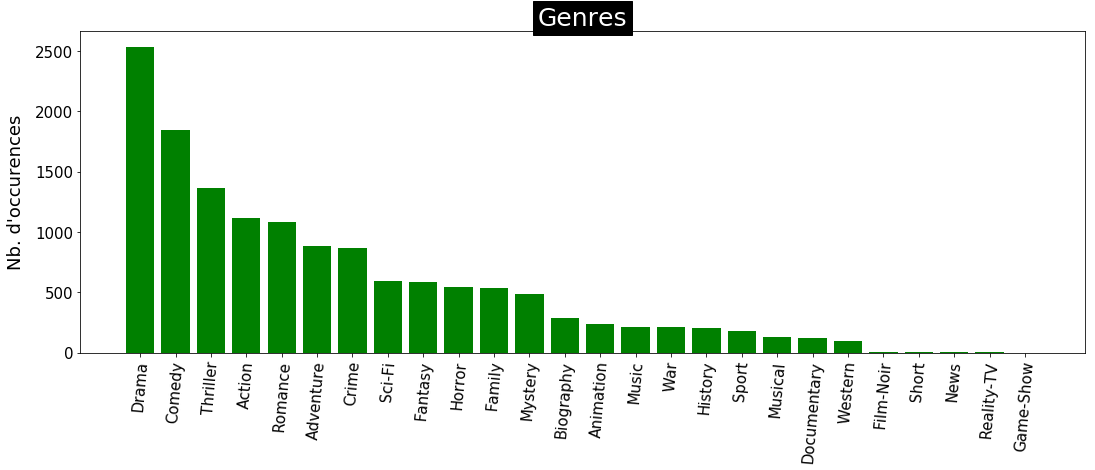

In [19]:
fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in genre_occurences]
x_axis = [k for k,i in enumerate(genre_occurences)]
x_label = [i[0] for i in genre_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("Nb. d'occurences", fontsize = 18, labelpad = 10)
ax2.bar(x_axis, y_axis, align = 'center', color='g')
#_______________________
plt.title("Genres",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 25)
plt.show()

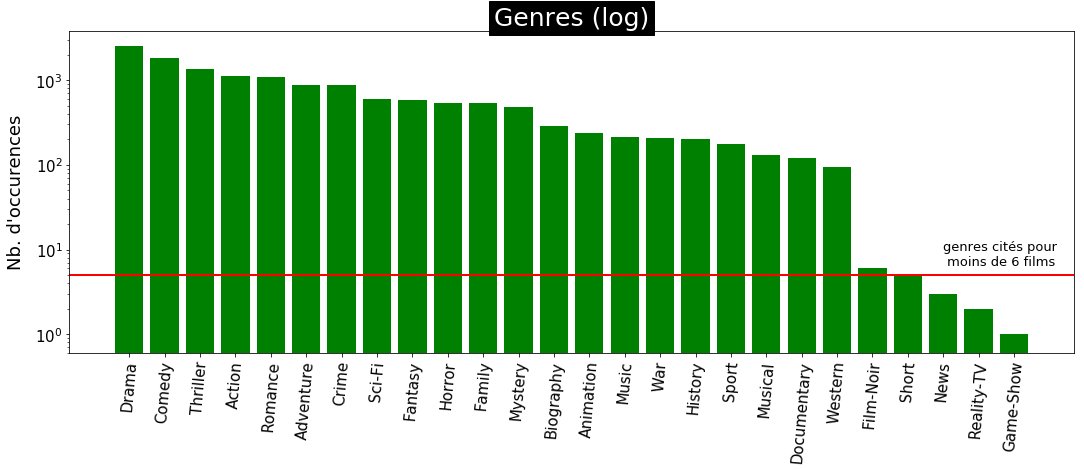

In [20]:
fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in genre_occurences]
x_axis = [k for k,i in enumerate(genre_occurences)]
x_label = [i[0] for i in genre_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("Nb. d'occurences", fontsize = 18, labelpad = 10)
plt.yscale('log')
plt.axhline(y=5, linewidth=2, color = 'r')
plt.text(23, 6.5, 'genres cités pour \n moins de 6 films', fontsize = 13)
ax2.bar(x_axis, y_axis, align = 'center', color='g')
#_______________________
plt.title("Genres (log)",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 25)
plt.show()

### 6.2 Plot_keywords
Combien de mots-clés sont utilisés pour au moins 6 films ?

In [21]:
# Etablissons la iste du vocabulaire complet des mots clés
keywords_set = set()
df_with_keywords = df[df.plot_keywords.notnull()]

for string in df_with_keywords['plot_keywords'].str.split('|').values:
    keywords_set = keywords_set.union(set(string))
    
# calculons le nombbre d'occurrences de chaque mot clé
keyword_occurences, dum = count_word(df_initial, 'plot_keywords', keywords_set)

# sélectionnons les mots clés utilisés par au moins 6 films
df_keyword_occurences = pd.DataFrame(keyword_occurences, columns = ['word', 'count'])
frequent_keywords = df_keyword_occurences[df_keyword_occurences['count'] > 5 ]
frequent_keywords.head()


,word,count
0,love,198
1,friend,166
2,murder,161
3,death,132
4,police,126


In [22]:
frequent_keywords.shape

(802, 2)

**802 mots clés sont cités pour au moins 6 films**

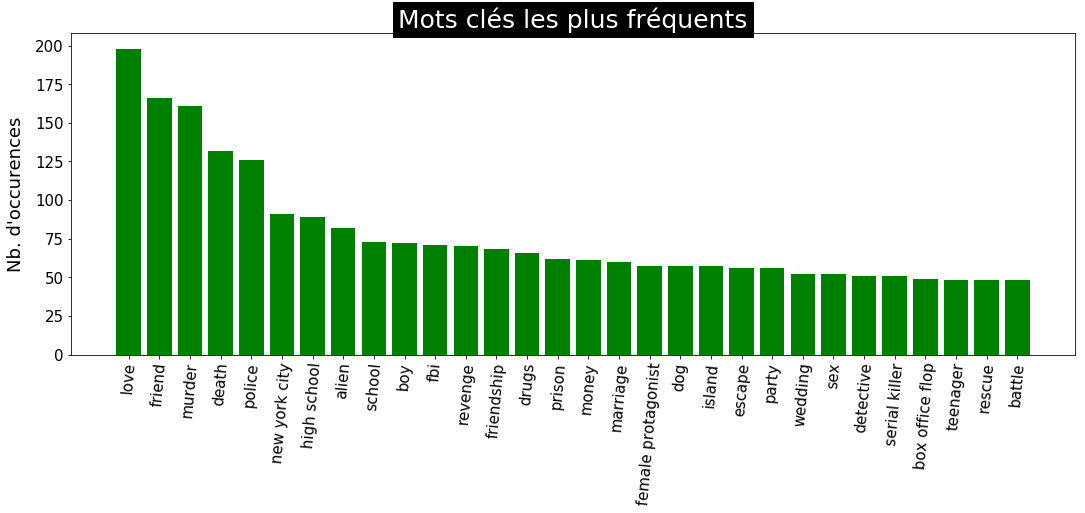

In [23]:
#visualisations les 30 mots clés les plus fréquents

fig_keywords = keyword_occurences[0:30]

fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in fig_keywords]
x_axis = [k for k,i in enumerate(fig_keywords)]
x_label = [i[0] for i in fig_keywords]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("Nb. d'occurences", fontsize = 18, labelpad = 10)
ax2.bar(x_axis, y_axis, align = 'center', color='g')
#_______________________
plt.title("Mots clés les plus fréquents",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 25)
plt.show()

In [24]:
keywords = []
i = 0
while i < df_keyword_occurences.shape[0] :
    keywords.append(df_keyword_occurences[0:i]['count'].sum())
    i += 1

#keywords

Text(0.5,0,'nombre de mots clés distincts')

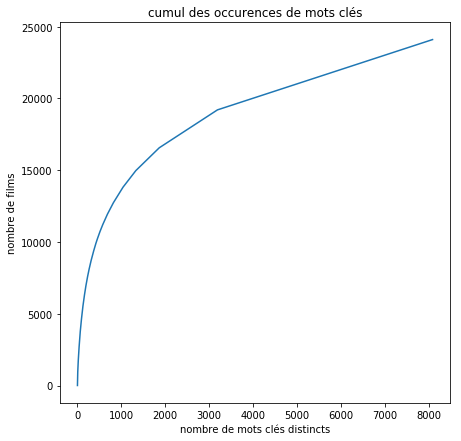

In [25]:
df_keyword_sum = pd.DataFrame(keywords, columns = ['count'])

fig, ax = plt.subplots(figsize = (7,7))
ax = sns.lineplot(x = df_keyword_sum.index, y = "count", data = df_keyword_sum )
ax.set_title('cumul des occurences de mots clés')
ax.set_ylabel('nombre de films')
ax.set_xlabel('nombre de mots clés distincts')

### 6.3 Directors


In [26]:
directors_labels = df['director_name'].unique()    
director_occurences, dum = count_word(df_initial, 'director_name', directors_labels)
director_occurences

df_director_count = pd.DataFrame(director_occurences, columns = ['director_name', 'nb_films'])
df_director_count.head()

,director_name,nb_films
0,Steven Spielberg,26
1,Woody Allen,22
2,Clint Eastwood,20
3,Martin Scorsese,20
4,Ridley Scott,17


In [27]:
total_directors = df ['director_name'].nunique()
total_directors

2397

**Il a 2397 directeurs distincts**

In [28]:
df_frequent_directors = df_director_count[df_director_count['nb_films'] > 1][['director_name', 'nb_films']].sort_values(by='nb_films', ascending = False)
df_frequent_directors.shape     

(894, 2)

** Il a 894 directeurs cités pour au moins 2 films**   
**Y a-t-il un sous ensemble de valeurs de director_name qui couvre la quasi-totalité des films ?**

In [29]:
films = []
i = 0
while i < df_director_count.shape[0] :
    films.append(df_director_count[0:i]['nb_films'].sum())
    i += 1

Text(0.5,0,'nombre de directeurs distincts')

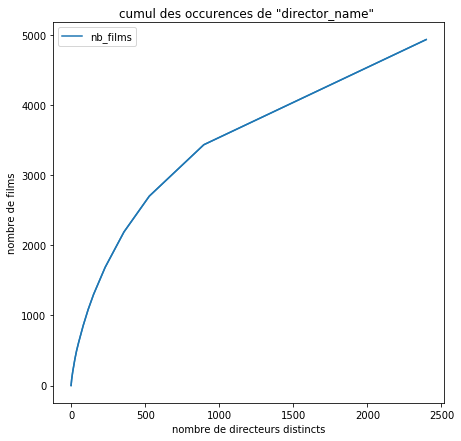

In [30]:
df_films = pd.DataFrame(films, columns = ['nb_films'] )

fig, ax = plt.subplots(figsize = (7,7))
sns.lineplot(x = df_films.index, y = "nb_films", data = df_films )
ax = sns.lineplot(data = df_films)
ax.set_title('cumul des occurences de "director_name" ')
ax.set_ylabel('nombre de films')
ax.set_xlabel('nombre de directeurs distincts')

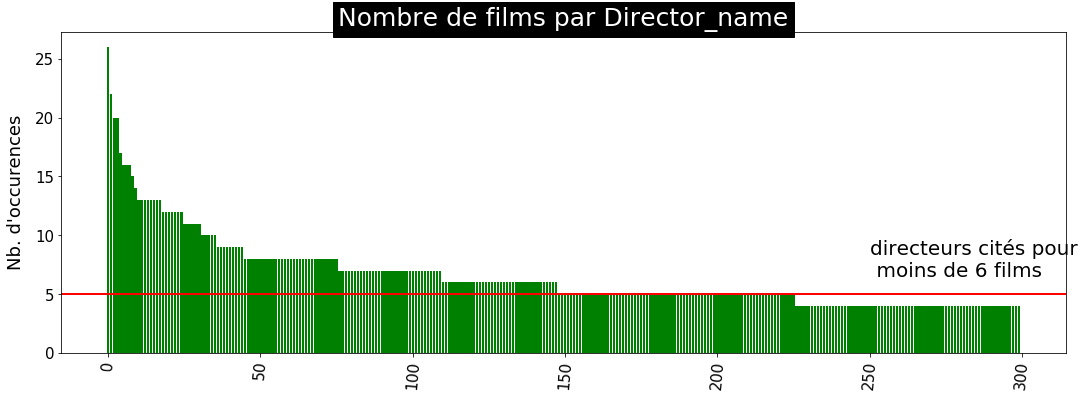

In [31]:
fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in director_occurences[0:300]]
x_axis = [k for k,i in enumerate(director_occurences[0:300])]
x_label = [i[0] for i in director_occurences[0:300]]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
#plt.xticks(x_axis, x_label)
plt.ylabel("Nb. d'occurences", fontsize = 18, labelpad = 10)
ax2.bar(x_axis, y_axis, align = 'center', color='g')
plt.axhline(y=5, linewidth=2, color = 'r')
plt.text(250, 6.5, 'directeurs cités pour \n moins de 6 films', fontsize = 20)
#_______________________
plt.title("Nombre de films par Director_name",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 25)
plt.show()

### 6.3 Acteurs

## 7. Distributions et Recherche de corrélations
Parmi les valeurs numériques, y a-t-il des corréations qui permettraient de réduire la dimension ?

In [32]:
numeric_columns = [
    'imdb_score','gross','movie_facebook_likes', 'num_voted_users','num_user_for_reviews','budget',\
    'director_facebook_likes','actor_1_facebook_likes', 'actor_2_facebook_likes','actor_3_facebook_likes',\
    'cast_total_facebook_likes', \
    'facenumber_in_poster'    
    ]

J'utilise un pairplot pour faire une exploration large, et je focaliserai sur des sujets d'intérêt si ils s'en présentent.

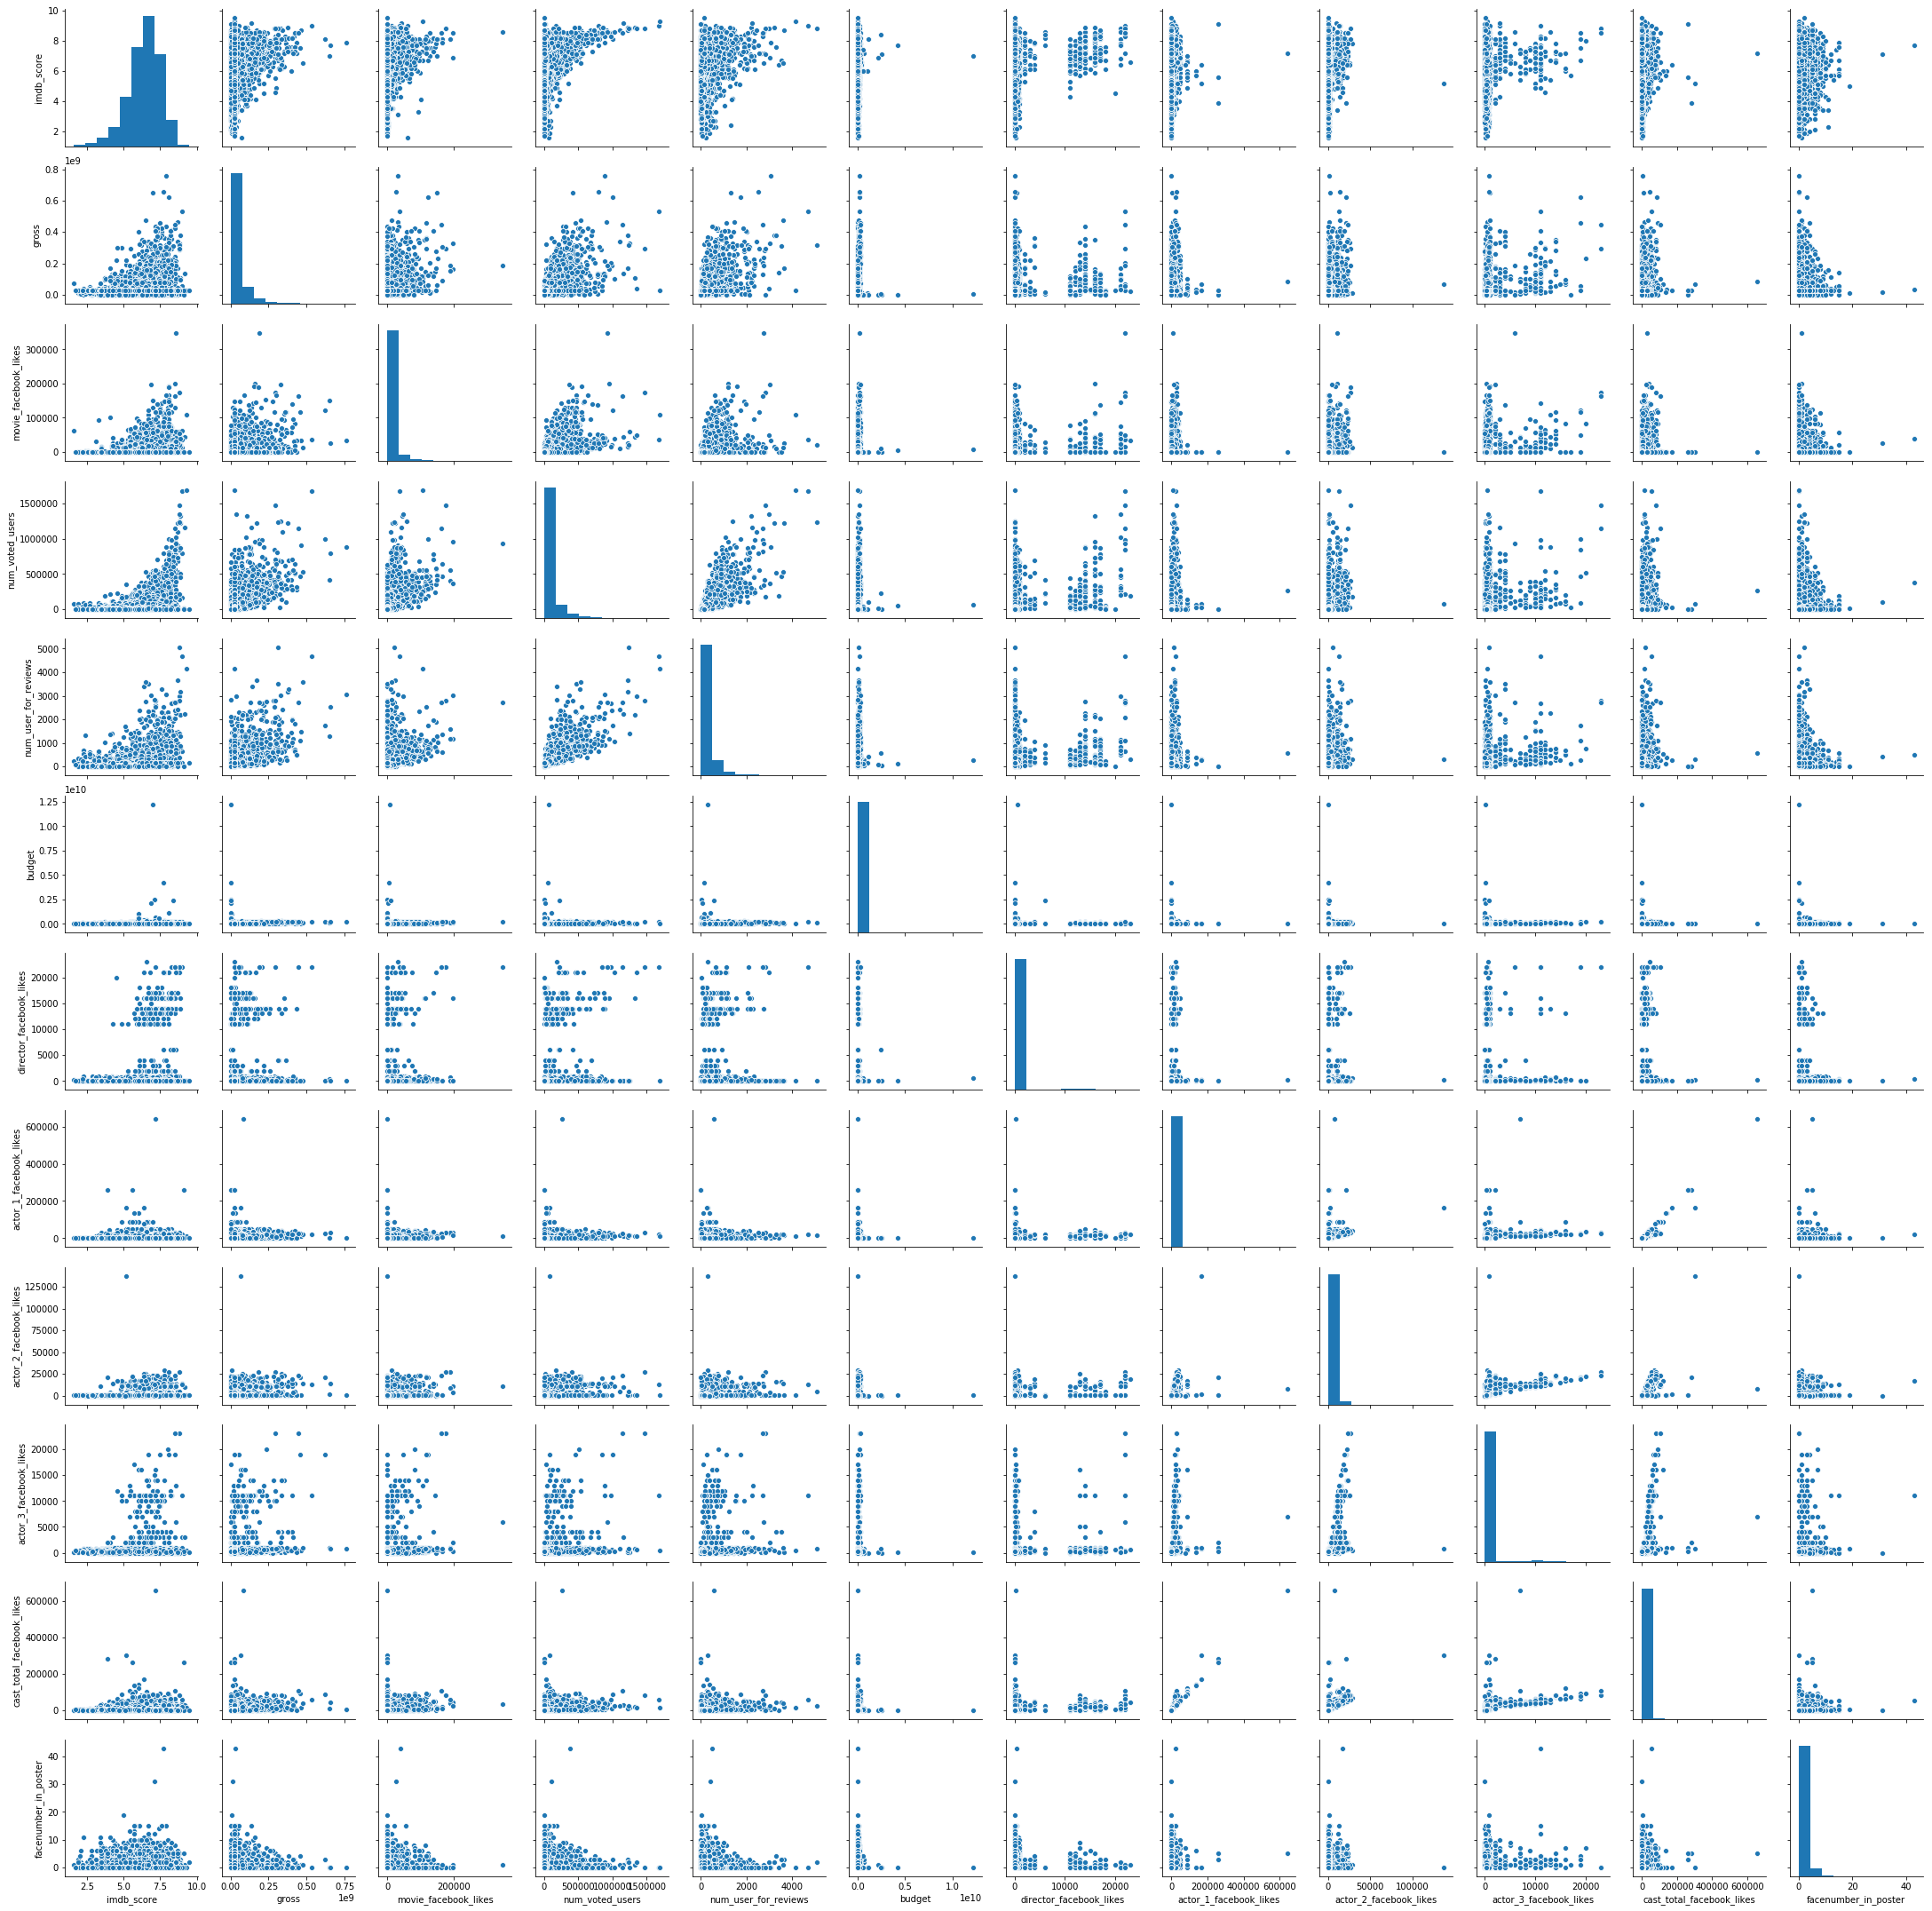

In [33]:
 g = sns.pairplot(df[numeric_columns])

In [34]:
corr = df[numeric_columns].corr()

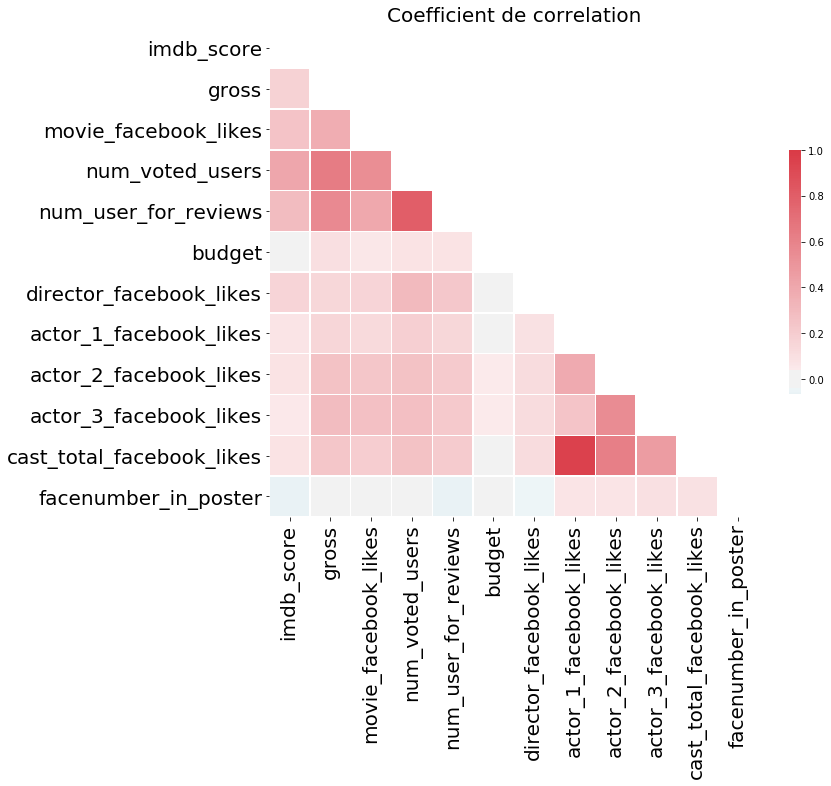

In [35]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio


ax = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.axes.set_title("Coefficient de correlation",fontsize=20)
ax.tick_params(labelsize=20)

**On peut conserver seulement cast_total_facebook_likes et exclure les likes facebooks des acteurs 1, 2 et 3 **